# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
# data processing
import math
import json
from multiprocessing import Pool, cpu_count
from multiprocessing.dummy import Pool as ThreadPool 
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

ImportError: No module named 'tqdm'

In [ ]:
# google
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from operator import itemgetter

In [ ]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [ ]:
# palette
sns.set(font_scale=1.5, style='whitegrid')
# sns.set_palette("cubehelix")
sns.set_palette(sns.cubehelix_palette(rot=-.4))

## Setup Google Sheets Auth

In [ ]:
# setup connection
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('credential.json', scope)
gc = gspread.authorize(credentials)

In [ ]:
def load_google_sheet_data(url, new_col_names=[]):
    """
    Loads in and returns post-study as a Pandas DataFrame with header remapped according to values above.
    
    Inputs:
        url (string): url of spreadsheet to load in
        new_col_names (list): list of strings for new column names
    
    Returns:
        (DataFrame): Pandas DataFrame with header remapped above
    """
    url_connection = gc.open_by_url(url)
    raw_data = url_connection.get_worksheet(0).get_all_values()
    
    output_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
    if len(new_col_names) > 0:
        output_df.columns = new_col_names

    return output_df

# Load in data

## Log Data from LES

In [ ]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
mid_time = '2018-03-12 05:00:00'
end_time = '2018-03-20 05:00:00'

start_time_date = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
mid_time_date = datetime.strptime(mid_time, '%Y-%m-%d %H:%M:%S')
end_time_date = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

print('Study Length: {}'.format(end_time_date - start_time_date))

In [ ]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in collection_list:
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

def load_data_parallel(url):
    return load_data(url, header, data, start_time, end_time)

In [ ]:
# fetch log data
urls = [url_4x, url_opp_location, url_opp_distance]
pool = ThreadPool(cpu_count())
results = pool.map(load_data_parallel, urls)
pool.close()
pool.join()

data_4x = results[0]
data_opp_loc = results[1]
data_opp_dist = results[2]

## Post-Study Survey Data

In [ ]:
replacement_dict = {
    '1: Very invaluable': 1,
    '2: Invaluable': 2,
    '3: Neutral': 3,
    '4: Valuable': 4,
    '5: Very valuable': 5,
    '1: Never': 1,
    '2: Rarely, in less than 10% of the notifications': 2,
    '3: Occasionally, in about 30% of the notifications': 3,
    '4: Sometimes, in about 50% of the notifications': 4,
    '5: Frequently, in about 70% of the notifications': 5,
    '6: Usually, in about 90% of the notifications': 6,
    '7: Every time I was notified': 7,
    '1: Not likely': 1,
    '2: Somewhat unlikely': 2,
    '3: Neutral': 3,
    '4: Somewhat likely': 4,
    '5: Very likely': 5,
    '1: Not disruptive, easy to do and continue on with my routine': 1,
    '2: Rarely disruptive': 2,
    '3: Occasionally disruptive': 3,
    '4: Moderately disruptive': 4,
    '5: A great deal disruptive, I had to stop what I was doing to answer': 5,
    '0: N/A': 0,
    '1: Far fewer than I would have liked': 1,
    '2: Fewer than I would have liked': 2,
    '3: About correct for the number I would have liked': 3,
    '4: More than I would have liked': 4,
    '5: Far more than I would have liked': 5,
    '': -1
}

In [2]:
# setup 4X post-survey data
url_4x = 'https://docs.google.com/spreadsheets/d/1rCH32DdAfnOSoe-qNIQgO7rQei2VATHxLlGfP0bCNg8/edit#gid=339656711'
cols_4x = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altprefs',
    'expand_info_disruption',
    'expand_info_number_notif',
    'exploit_atloc',
    'exploit_enroute',
    'exploit_disruption',
    'miscellaneous'
]
post_study_4x = load_google_sheet_data(url_4x, new_col_names=cols_4x)
post_study_4x.replace(to_replace=replacement_dict, inplace=True)
post_study_4x['overall_disruption'] = (2/3) * post_study_4x['overall_disruption'] + (1/3)

# remove bad users
post_study_4x = post_study_4x[post_study_4x['email_address'] != 'jamiekuhn2019@u.northwestern.edu']

post_study_4x.to_csv('./analysis/post_study_4x.csv', index=False)
post_study_4x.head(1)

NameError: name 'load_google_sheet_data' is not defined

In [3]:
# setup opp at location post-survey data
url_opp_loc = 'https://docs.google.com/spreadsheets/d/15x6yST-eJh1azQJxQRtkOb37E397RJhzG-3CDbPCflk/edit#gid=1062479755'
cols_opp_loc = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'miscellaneous'
]
post_study_opp_loc = load_google_sheet_data(url_opp_loc, new_col_names=cols_opp_loc)
post_study_opp_loc.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_loc['overall_disruption'] = (2/3) * post_study_opp_loc['overall_disruption'] + (1/3)

post_study_opp_loc.to_csv('./analysis/post_study_opp_loc.csv', index=False)
post_study_opp_loc.head(1)

NameError: name 'load_google_sheet_data' is not defined

In [4]:
# setup opp at distance post-survey data
url_opp_dist = 'https://docs.google.com/spreadsheets/d/1YJVo7ouNklEXb1DLZlzGttoaTDk-z2WJxVPIRmB5hyw/edit#gid=446248525'
cols_opp_dist = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_noinfo',
    'expand_noinfo_disruption',
    'expand_noinfo_number_notif',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altpref',
    'expand_info_disruption',
    'expand_info_number_notif',
    'miscellaneous'
]
post_study_opp_dist = load_google_sheet_data(url_opp_dist, new_col_names=cols_opp_dist)
post_study_opp_dist.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_dist['overall_disruption'] = (2/3) * post_study_opp_dist['overall_disruption'] + (1/3)

post_study_opp_dist.to_csv('./analysis/post_study_opp_dist.csv', index=False)
post_study_opp_dist.head(1)

NameError: name 'load_google_sheet_data' is not defined

# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [33]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.sort_values('createdAt', inplace=True)
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.sort_values('createdAt', inplace=True)
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='Missed Notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'Dismissed Notification'
    atloc.loc[atloc['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [34]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.sort_values('createdAt', inplace=True)
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.sort_values('createdAt', inplace=True)
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='Missed Notification')
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)
    
    # remap columns
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'Dismissed Notification'

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [35]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.sort_values('createdAt', inplace=True)
    enroutenotif.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    enrouteresp.sort_values('createdAt', inplace=True)
    enrouteresp.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId']],
                            how='left', on=['enRouteLocationId', 'vendorId'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='Missed Notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'Dismissed Notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    enroute.loc[enroute['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [36]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [37]:
location_scaffolds = {}
for index, row in data_4x['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']

## 4X Log Data Setup

In [38]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [39]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])
enroutelocations_4x = deepcopy(data_4x['EnRouteLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

foryou_4x = deepcopy(data_4x['ForYouViewLog'])

print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif_4x), len(atlocresp_4x)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif_4x), len(atdistresp_4x)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif_4x), len(enrouteresp_4x)))

4X | At location notifications: 735, At location responses: 333
4X | At distance notifications: 206, At distance responses: 126
4X | En route notifications: 15, En route responses: 1


In [40]:
# remove bad users
bad_users_4x = ['0E322CAE-1091-4C9D-835F-24C36AA2A4D7']

atlocnotif_4x = atlocnotif_4x[~atlocnotif_4x['vendorId'].isin(bad_users_4x)]
atlocresp_4x = atlocresp_4x[~atlocresp_4x['vendorId'].isin(bad_users_4x)]

atdistnotif_4x = atdistnotif_4x[~atdistnotif_4x['vendorId'].isin(bad_users_4x)]
atdistresp_4x = atdistresp_4x[~atdistresp_4x['vendorId'].isin(bad_users_4x)]

enroutenotif_4x = enroutenotif_4x[~enroutenotif_4x['vendorId'].isin(bad_users_4x)]
enrouteresp_4x = enrouteresp_4x[~enrouteresp_4x['vendorId'].isin(bad_users_4x)]

foryou_4x = foryou_4x[~foryou_4x['vendorId'].isin(bad_users_4x)]

users_4x = users_4x[~users_4x['vendorId'].isin(bad_users_4x)]

print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif_4x), len(atlocresp_4x)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif_4x), len(atdistresp_4x)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif_4x), len(enrouteresp_4x)))

4X | At location notifications: 673, At location responses: 300
4X | At distance notifications: 201, At distance responses: 123
4X | En route notifications: 15, En route responses: 1


In [41]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

# add date and week
atloc_4x['date'] = pd.to_datetime(atloc_4x['notificationTimestamp'] + atloc_4x['gmtOffset'], unit='s').dt.date
atloc_4x['week'] = atloc_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [42]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded'] == True] # 4X Only: remove cases without info

# add date and week
atdist_4x['date'] = pd.to_datetime(atdist_4x['notificationTimestamp'] + atdist_4x['gmtOffset'], unit='s').dt.date
atdist_4x['week'] = atdist_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [43]:
# eXpand providing more data at location overall
atdist_4x_overall_moreinfo = atdist_4x[atdist_4x['emaResponse'].isin(["Yes! This info is useful, I'm going now.", "Yes. This info is useful but I'm already going there."])]
atdist_4x_overall_moreinfo = atdist_4x_overall_moreinfo.merge(atloc_4x, how='left', on=['vendorId', 'taskLocationId'])
atdist_4x_overall_moreinfo['remappedResponses'].fillna(value='Did Not Go', inplace=True)
atdist_4x_overall_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,locationName_y,gmtOffset_y,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y
0,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-21600.0,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520283e+09,2018-03-05,Week 1
1,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-21600.0,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,no,Valid Response,1.520283e+09,2018-03-05,Week 1
2,vKrOItaLeS,F869C396-591A-4F19-895B-5E5871924B45,,301.857400,344.121791,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,Ford Ground Floor (by the staircase),-21600.0,1.520456e+09,"Notified for vKrOItaLeS (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520457e+09,2018-03-07,Week 1
3,vKrOItaLeS,F57CB6D4-09B3-4796-AE91-2F31BADEE832,,219.747081,316.048657,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN
4,ZBmWUZNqau,D3D3D1E2-1F39-4AB8-917D-52876AA63830,ekGHD1UW0G,300.553510,1.191497,coffeeshop,Starbucks (in Norris),300,geofence trip,True,...,Starbucks (in Norris),-21600.0,1.520545e+09,Notified for beacon region ekGHD1UW0G,sharedseatingoutlets,no,Valid Response,1.520545e+09,2018-03-08,Week 1
5,SfFmjmE7wD,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,cE9k7N4F4I,269.546308,38.521418,gym,Blomquist,300,geofence trip,True,...,Blomquist,-18000.0,1.521506e+09,Notified for beacon region cE9k7N4F4I,Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-19,Week 2


In [61]:
atdist_4x_overall_moreinfo['time_diff_seconds'] = (atdist_4x_overall_moreinfo['notificationTimestamp_y'].fillna(0) - atdist_4x_overall_moreinfo['responseTimestamp_x']).astype(int)
atdist_4x_overall_moreinfo['time_diff_minutes'] = atdist_4x_overall_moreinfo['time_diff_seconds'] / 60
atdist_4x_overall_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y,time_diff_seconds,time_diff_minutes
0,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520283e+09,2018-03-05,Week 1,227,3.783333e+00
1,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,no,Valid Response,1.520283e+09,2018-03-05,Week 1,157,2.616667e+00
2,vKrOItaLeS,F869C396-591A-4F19-895B-5E5871924B45,,301.857400,344.121791,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,1.520456e+09,"Notified for vKrOItaLeS (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520457e+09,2018-03-07,Week 1,211,3.516667e+00
3,vKrOItaLeS,F57CB6D4-09B3-4796-AE91-2F31BADEE832,,219.747081,316.048657,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520456621,-2.534094e+07
4,ZBmWUZNqau,D3D3D1E2-1F39-4AB8-917D-52876AA63830,ekGHD1UW0G,300.553510,1.191497,coffeeshop,Starbucks (in Norris),300,geofence trip,True,...,1.520545e+09,Notified for beacon region ekGHD1UW0G,sharedseatingoutlets,no,Valid Response,1.520545e+09,2018-03-08,Week 1,308,5.133333e+00
5,SfFmjmE7wD,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,cE9k7N4F4I,269.546308,38.521418,gym,Blomquist,300,geofence trip,True,...,1.521506e+09,Notified for beacon region cE9k7N4F4I,Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-19,Week 2,1797,2.995000e+01


In [723]:
atdist_4x_overall_moreinfo.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,emaResponse,remappedResponses,count
0,"Yes! This info is useful, I'm going now.","""I don't know"" Response",2
1,"Yes! This info is useful, I'm going now.",Missed Notification,1
2,"Yes! This info is useful, I'm going now.",Valid Response,1
3,Yes. This info is useful but I'm already going...,Did Not Go,1
4,Yes. This info is useful but I'm already going...,Valid Response,1


In [724]:
# eXpand providing more data at location if deviating
atdist_4x_deviate_moreinfo = atdist_4x[atdist_4x['emaResponse'].isin(["Yes! This info is useful, I'm going now."])]
atdist_4x_deviate_moreinfo = atdist_4x_deviate_moreinfo.merge(atloc_4x, how='left', on=['vendorId', 'taskLocationId'])
atdist_4x_deviate_moreinfo['remappedResponses'].fillna(value='Did Not Go', inplace=True)
atdist_4x_deviate_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,locationName_y,gmtOffset_y,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y
0,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-21600,1520282501,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1520282622,2018-03-05,Week 1
1,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-21600,1520282737,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,no,Valid Response,1520282928,2018-03-05,Week 1
2,vKrOItaLeS,F869C396-591A-4F19-895B-5E5871924B45,,301.857400,344.121791,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,Ford Ground Floor (by the staircase),-21600,1520456392,"Notified for vKrOItaLeS (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1520457313,2018-03-07,Week 1
3,SfFmjmE7wD,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,cE9k7N4F4I,269.546308,38.521418,gym,Blomquist,300,geofence trip,True,...,Blomquist,-18000,1521506429,Notified for beacon region cE9k7N4F4I,Missed Notification,Missed Notification,Missed Notification,-1,2018-03-19,Week 2


In [63]:
# merged data from with all EnRoute data
enroute_4x = get_merged_en_route(deepcopy(enroutelocations_4x),
                                 deepcopy(enroutenotif_4x),
                                 deepcopy(enrouteresp_4x))
enroute_4x['date'] = pd.to_datetime(enroute_4x['notificationTimestamp'] + enroute_4x['gmtOffset'], unit='s').dt.date
enroute_4x['week'] = enroute_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [64]:
foryou_4x['date'] = pd.to_datetime(foryou_4x['timestamp'] + foryou_4x['gmtOffset'], unit='s').dt.date
foryou_4x['week'] = foryou_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

## Opp at Distance Log Data Setup

In [65]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [66]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

foryou_opp_dist = deepcopy(data_opp_dist['ForYouViewLog'])

In [67]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))
atloc_opp_dist['date'] = pd.to_datetime(atloc_opp_dist['notificationTimestamp'] + atloc_opp_dist['gmtOffset'], unit='s').dt.date
atloc_opp_dist['week'] = atloc_opp_dist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [68]:
# remove bad data instance
atdistnotif_opp_dist = atdistnotif_opp_dist[atdistnotif_opp_dist['objectId'] != 'yoAu9NyqWh']

In [69]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))
atdist_opp_dist['date'] = pd.to_datetime(atdist_opp_dist['notificationTimestamp'] + atdist_opp_dist['gmtOffset'], unit='s').dt.date
atdist_opp_dist['week'] = atdist_opp_dist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [70]:
atdist_opp_dist['emaResponse'].unique().tolist()

['No. This info is useful but I have to be somewhere.',
 'Missed Notification',
 "No. This info isn't useful to me.",
 "No. I don't want to go out of my way there.",
 'No. Other reason.',
 'Sure! I would be happy to go out of my way!',
 'Sure, but I was going to walk past it anyway.',
 'Dismissed Notification',
 "Yes. This info is useful but I'm already going there.",
 "Yes! This info is useful, I'm going now."]

In [71]:
# eXpand providing more data overall
atdist_opp_dist_overall_moreinfo = atdist_opp_dist[atdist_opp_dist['emaResponse'].isin(["Yes! This info is useful, I'm going now.", "Yes. This info is useful but I'm already going there.", 'Sure! I would be happy to go out of my way!', 'Sure, but I was going to walk past it anyway.'])]
atdist_opp_dist_overall_moreinfo = atdist_opp_dist_overall_moreinfo.merge(atloc_opp_dist, how='left', on=['vendorId', 'taskLocationId'])
atdist_opp_dist_overall_moreinfo['remappedResponses'].fillna(value='Did Not Go', inplace=True)
atdist_opp_dist_overall_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,locationName_y,gmtOffset_y,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y
0,HA6rAA7J7h,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,U6dNrYsSyk,251.243893,107.549470,gym,SPAC,300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN
1,1F7hormE2R,8A07FCFF-F609-4DA2-BD9A-81CD0E86A518,,325.349493,10.340679,coffeeshop,Coffee Lab,300,geofence trip,False,...,Coffee Lab,-21600.0,1.520297e+09,"Notified for 1F7hormE2R (42.058332, -87.683737...",privateseating,tables and couches/chairs,Valid Response,1.520297e+09,2018-03-05,Week 1
2,F4xVwo61dK,282EBA67-4C26-4BAF-AC6F-5785BA07B7DF,,14.712909,259.393379,coffeeshop,Coffee Lab,300,geofence trip,False,...,Coffee Lab,-21600.0,1.520351e+09,"Notified for F4xVwo61dK (42.058332, -87.683737...",Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-06,Week 1
3,0gXxh0m82r,B40B49C0-B139-49B3-A36D-52EEB62932FF,ekGHD1UW0G,340.746404,23.779529,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,Starbucks (in Norris),-21600.0,1.520379e+09,Notified for beacon region ekGHD1UW0G,sharedseating,no,Valid Response,1.520379e+09,2018-03-06,Week 1
4,zvzu6GothP,B3342593-A72F-4715-B728-F82852432A4C,3xNa2peiRk,331.599398,4.288054,workspace,Main 1South,300,geofence trip,False,...,Main 1South,-21600.0,1.520373e+09,Notified for beacon region 3xNa2peiRk,privateseating,tables and couches/chairs,Valid Response,1.520373e+09,2018-03-06,Week 1
5,OWyftq005s,E4A014FD-FA9A-42A2-A819-B8F989B3DF2C,3xNa2peiRk,214.252326,13.936016,workspace,Main 1South,300,geofence trip,True,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN
6,klS5rCQuyV,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,Y6oyD2IvMA,244.692654,0.279468,workspace,Mudd Common Area (outside library),300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN
7,C4Zv4RE1th,B3342593-A72F-4715-B728-F82852432A4C,3xNa2peiRk,331.604702,47.581867,workspace,Main 1South,300,geofence trip,False,...,Main 1South,-21600.0,1.520449e+09,Notified for beacon region 3xNa2peiRk,privateseating,tables and couches/chairs,Valid Response,1.520449e+09,2018-03-07,Week 1
8,49hHGCcdG7,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,,299.584633,0.819132,coffeeshop,Coffee Lab,300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN
9,z3lgf4TcT2,01A01759-AFFD-46F4-8667-0EC396F804D7,,232.132471,110.958952,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,NaN,NaN,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN


In [72]:
atdist_opp_dist_overall_moreinfo['time_diff_seconds'] = (atdist_opp_dist_overall_moreinfo['notificationTimestamp_y'].fillna(0) - atdist_opp_dist_overall_moreinfo['responseTimestamp_x']).astype(int)
atdist_opp_dist_overall_moreinfo['time_diff_minutes'] = atdist_opp_dist_overall_moreinfo['time_diff_seconds'] / 60
atdist_opp_dist_overall_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y,time_diff_seconds,time_diff_minutes
0,HA6rAA7J7h,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,U6dNrYsSyk,251.243893,107.549470,gym,SPAC,300,geofence trip,False,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520297443,-2.533829e+07
1,1F7hormE2R,8A07FCFF-F609-4DA2-BD9A-81CD0E86A518,,325.349493,10.340679,coffeeshop,Coffee Lab,300,geofence trip,False,...,1.520297e+09,"Notified for 1F7hormE2R (42.058332, -87.683737...",privateseating,tables and couches/chairs,Valid Response,1.520297e+09,2018-03-05,Week 1,32,5.333333e-01
2,F4xVwo61dK,282EBA67-4C26-4BAF-AC6F-5785BA07B7DF,,14.712909,259.393379,coffeeshop,Coffee Lab,300,geofence trip,False,...,1.520351e+09,"Notified for F4xVwo61dK (42.058332, -87.683737...",Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-06,Week 1,-30,-5.000000e-01
3,0gXxh0m82r,B40B49C0-B139-49B3-A36D-52EEB62932FF,ekGHD1UW0G,340.746404,23.779529,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,1.520379e+09,Notified for beacon region ekGHD1UW0G,sharedseating,no,Valid Response,1.520379e+09,2018-03-06,Week 1,116,1.933333e+00
4,zvzu6GothP,B3342593-A72F-4715-B728-F82852432A4C,3xNa2peiRk,331.599398,4.288054,workspace,Main 1South,300,geofence trip,False,...,1.520373e+09,Notified for beacon region 3xNa2peiRk,privateseating,tables and couches/chairs,Valid Response,1.520373e+09,2018-03-06,Week 1,289,4.816667e+00
5,OWyftq005s,E4A014FD-FA9A-42A2-A819-B8F989B3DF2C,3xNa2peiRk,214.252326,13.936016,workspace,Main 1South,300,geofence trip,True,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520442484,-2.534071e+07
6,klS5rCQuyV,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,Y6oyD2IvMA,244.692654,0.279468,workspace,Mudd Common Area (outside library),300,geofence trip,False,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520457858,-2.534096e+07
7,C4Zv4RE1th,B3342593-A72F-4715-B728-F82852432A4C,3xNa2peiRk,331.604702,47.581867,workspace,Main 1South,300,geofence trip,False,...,1.520449e+09,Notified for beacon region 3xNa2peiRk,privateseating,tables and couches/chairs,Valid Response,1.520449e+09,2018-03-07,Week 1,250,4.166667e+00
8,49hHGCcdG7,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,,299.584633,0.819132,coffeeshop,Coffee Lab,300,geofence trip,False,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520462727,-2.534105e+07
9,z3lgf4TcT2,01A01759-AFFD-46F4-8667-0EC396F804D7,,232.132471,110.958952,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,NaN,NaN,NaN,NaN,Did Not Go,NaN,NaN,NaN,-1520468059,-2.534113e+07


In [77]:
atdist_opp_dist_overall_moreinfo[atdist_opp_dist_overall_moreinfo['time_diff_minutes'] > 0]['time_diff_minutes'].describe()

count     21.000000
mean      32.544444
std       53.032714
min        0.533333
25%        2.833333
50%       10.566667
75%       36.233333
max      228.933333
Name: time_diff_minutes, dtype: float64

In [73]:
atdist_opp_dist_overall_moreinfo.groupby(['emaResponse', 'remappedResponses'])['remappedResponses'].count().reset_index(name='count')

,emaResponse,remappedResponses,count
0,Sure! I would be happy to go out of my way!,Did Not Go,7
1,Sure! I would be happy to go out of my way!,Missed Notification,1
2,Sure! I would be happy to go out of my way!,Valid Response,3
3,"Sure, but I was going to walk past it anyway.","""I don't know"" Response",1
4,"Sure, but I was going to walk past it anyway.",Did Not Go,19
5,"Sure, but I was going to walk past it anyway.",Missed Notification,5
6,"Sure, but I was going to walk past it anyway.",Valid Response,10
7,"Yes! This info is useful, I'm going now.",Did Not Go,1
8,"Yes! This info is useful, I'm going now.",Missed Notification,1
9,"Yes! This info is useful, I'm going now.",Valid Response,2


In [74]:
# eXpand providing more data if deviate
atdist_opp_dist_deviate_moreinfo = atdist_opp_dist[atdist_opp_dist['emaResponse'].isin(["Yes! This info is useful, I'm going now.", 'Sure! I would be happy to go out of my way!'])]
atdist_opp_dist_deviate_moreinfo = atdist_opp_dist_deviate_moreinfo.merge(atloc_opp_dist, how='left', on=['vendorId', 'taskLocationId'])
atdist_opp_dist_deviate_moreinfo

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,locationName_y,gmtOffset_y,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y,week_y
0,HA6rAA7J7h,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,U6dNrYsSyk,251.243893,107.549470,gym,SPAC,300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0gXxh0m82r,B40B49C0-B139-49B3-A36D-52EEB62932FF,ekGHD1UW0G,340.746404,23.779529,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,Starbucks (in Norris),-21600.0,1.520379e+09,Notified for beacon region ekGHD1UW0G,sharedseating,no,Valid Response,1.520379e+09,2018-03-06,Week 1
2,9lvjIWmHUe,D017ACD7-9AFE-4FB7-B0B2-1B74E57B93F5,ekGHD1UW0G,283.032198,139.881952,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mpKyLs7s7O,086AFB2A-294D-495E-9BD2-19B22C179C00,ekGHD1UW0G,304.637187,20.290322,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tt4i1MtXSI,B40B49C0-B139-49B3-A36D-52EEB62932FF,Y6oyD2IvMA,300.348252,29.043214,workspace,Mudd Common Area (outside library),300,geofence trip,True,...,Mudd Common Area (outside library),-18000.0,1.520824e+09,Notified for beacon region Y6oyD2IvMA,privateseatingoutlets,yes,Valid Response,1.520824e+09,2018-03-11,Week 1
5,H6tqPqQW6P,B40B49C0-B139-49B3-A36D-52EEB62932FF,ekGHD1UW0G,314.730925,78.360784,coffeeshop,Starbucks (in Norris),300,geofence trip,False,...,Starbucks (in Norris),-18000.0,1.520809e+09,Notified for beacon region ekGHD1UW0G,privateseating,tables,Valid Response,1.520809e+09,2018-03-11,Week 1
6,2kkunCMPvY,D017ACD7-9AFE-4FB7-B0B2-1B74E57B93F5,,88.841146,154.727799,coffeeshop,Starbucks (on Sherman),300,geofence trip,False,...,Starbucks (on Sherman),-18000.0,1.520871e+09,"Notified for 2kkunCMPvY (42.049684, -87.682083...",Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-12,Week 2
7,OShnx6CkeL,D017ACD7-9AFE-4FB7-B0B2-1B74E57B93F5,,235.464535,294.168165,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-18000.0,1.521053e+09,"Notified for OShnx6CkeL (42.057016, -87.676649...",stillleft,no,Valid Response,1.521062e+09,2018-03-14,Week 2
8,OShnx6CkeL,2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A,,320.814311,62.934011,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,Ford Second Floor (outside McCormick Career De...,-18000.0,1.521056e+09,"Notified for OShnx6CkeL (42.057016, -87.676649...",Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-14,Week 2
9,OGHm8PsUWY,086AFB2A-294D-495E-9BD2-19B22C179C00,,328.077701,42.619706,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [736]:
foryou_opp_dist['date'] = pd.to_datetime(foryou_opp_dist['timestamp'] + foryou_opp_dist['gmtOffset'], unit='s').dt.date
foryou_opp_dist['week'] = foryou_opp_dist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

## Opp at Location Log Data Setup

In [737]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [738]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

foryou_opp_loc = deepcopy(data_opp_loc['ForYouViewLog'])

In [739]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))
atloc_opp_loc['date'] = pd.to_datetime(atloc_opp_loc['notificationTimestamp'] + atloc_opp_loc['gmtOffset'], unit='s').dt.date
atloc_opp_loc['week'] = atloc_opp_loc['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [740]:
foryou_opp_loc['date'] = pd.to_datetime(foryou_opp_loc['timestamp'] + foryou_opp_loc['gmtOffset'], unit='s').dt.date
foryou_opp_loc['week'] = foryou_opp_loc['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

# Pre-Study Demographics

In [741]:
cols_pre_study = [
    'timestamp',
    'name',
    'email_address',
    'gender',
    'age',
    'student_type',
    'schools',
    'class_areas',
    'iphone_type',
    'has_apple_watch',
    'coffeeshop_interests',
    'workspace_interests',
    'gym_interests',
    'freefood_interests',
    'study_conditions'
]
pre_study_url = 'https://docs.google.com/spreadsheets/d/1ZIC3FjmrHLbvYLBeV893ic95v3S9xflFO5o9vNXkHlQ/edit#gid=1936734879'
pre_study_data = load_google_sheet_data(pre_study_url, new_col_names=cols_pre_study)
pre_study_data.drop(['timestamp', 'name', 'coffeeshop_interests', 'workspace_interests',
                     'gym_interests', 'freefood_interests', 'study_conditions'], axis=1, inplace=True)

In [742]:
user_demographics_4x = users_4x[['vendorId', 'username']].merge(pre_study_data, left_on='username', right_on='email_address', how='left')
user_demographics_4x['age'] = user_demographics_4x['age'].astype(int)
average_age_4x = user_demographics_4x[user_demographics_4x['age'] > 0]['age'].mean()

print('Mean 4X User Age: {:1.2f}'.format(average_age_4x))
user_demographics_4x.groupby('gender')['gender'].count().reset_index(name='count')

Mean 4X User Age: 20.52


,gender,count
0,Female,21
1,Male,9


In [743]:
user_demographics_opp_loc = users_opp_loc[['vendorId', 'username']].merge(pre_study_data, left_on='username', right_on='email_address', how='left')
user_demographics_opp_loc['age'] = user_demographics_opp_loc['age'].astype(int)
average_age_opp_loc = user_demographics_opp_loc[user_demographics_opp_loc['age'] > 0]['age'].mean()

print('Mean Opportunistic at Location User Age: {:1.2f}'.format(average_age_opp_loc))
user_demographics_opp_loc.groupby('gender')['gender'].count().reset_index(name='count')

Mean Opportunistic at Location User Age: 19.74


,gender,count
0,Female,24
1,Male,8


In [744]:
user_demographics_opp_dist = users_opp_dist[['vendorId', 'username']].merge(pre_study_data, left_on='username', right_on='email_address', how='left')
user_demographics_opp_dist['age'] = user_demographics_opp_dist['age'].astype(int)
average_age_opp_dist = user_demographics_opp_dist[user_demographics_opp_dist['age'] > 0]['age'].mean()

print('Mean Opportunistic at Distance User Age: {:1.2f}'.format(average_age_opp_dist))
user_demographics_opp_dist.groupby('gender')['gender'].count().reset_index(name='count')

Mean Opportunistic at Distance User Age: 20.66


,gender,count
0,Female,27
1,Male,5


In [745]:
all_users = pd.concat([user_demographics_4x, user_demographics_opp_loc, user_demographics_opp_dist])
average_age_all = all_users[all_users['age'] > 0]['age'].mean()
sd_age_all = all_users[all_users['age'] > 0]['age'].std()
min_age_all = all_users[all_users['age'] > 0]['age'].min()
max_age_all = all_users[all_users['age'] > 0]['age'].max()

print('All Participants: Mean Age = {:1.2f}, Std Age = {:1.2f}, Min Age = {}, Max Age = {}'.format(average_age_all, sd_age_all, min_age_all, max_age_all))
all_users.groupby('gender')['gender'].count().reset_index(name='count')

All Participants: Mean Age = 20.30, Std Age = 1.93, Min Age = 18, Max Age = 28


,gender,count
0,Female,72
1,Male,22


# Intermediate Aggregations
This section of the notebook is used to create any intermediate tables that will be used later on to create tables, graphs, and conduct more complex analysis.

In [746]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for location_col and response_col to aggregate on.
        location_col (string): column containing location to aggregate on (e.g. locationType, locationName)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1)
    
    return combined_byloc

In [747]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['Total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

In [748]:
def compute_bytime_counts_overall(data, date_col, response_col):
    """
    Computes and returns a DataFrame with counts of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        date_col (string): column containing date/time to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([date_col, response_col])[response_col].count().reset_index(name='count')
    
    return combined_overall

In [749]:
def compute_bytime_prop_overall(data, date_col, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        date_col (string): column containing date/time to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([date_col, response_col])[response_col].count()
    combined_overall = combined_overall.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index(name='percentage')
    
    return combined_overall

In [750]:
def compute_valid_count_prop_byuser(data, users, user_col, response_col, valid_responses):
    """
    Computes and returns a groupby DataFrame with counts and proportions of valid responses, by user.
    
    Input:
        data (DataFrame): must include columns for user_col and response_col to aggregate on.
        users (DataFrame): users to include for no responses
        user_col (string): column containing users to aggregate on (e.g. vendorId)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
        valid_responses (list of strings): list of valid responses to include in final output
    
    Output:
        (groupby DataFrame): aggregated data when valid response exists, by user
    """
    count_byuser = data.groupby([user_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byuser = count_byuser.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byuser, prop_byuser], axis=1).reset_index()
    
    # isolate only valid responses and return
    combined_byloc = combined_byloc[combined_byloc[response_col].isin(valid_responses)].reset_index(drop=True)
    
    # include all people in dataframe
    combined_byloc = combined_byloc.merge(users[['objectId', 'vendorId']], how='right')
    del combined_byloc['objectId']
    
    # fill blanks
    combined_byloc.fillna(value={
        response_col: 'No Responses',
        'count': 0,
        'count_proportion': 0.0
    }, inplace=True)
    
    return combined_byloc

## 4X: At Location

In [751]:
atloc_4x_count_prop_byloc = compute_count_prop_byloc(atloc_4x, 'locationType', 'remappedResponses')

In [752]:
atloc_4x_count_prop_overall = compute_count_prop_overall(atloc_4x, 'remappedResponses')

In [753]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 30


In [754]:
atloc_4x_valid_responses = ['Valid Response']
atloc_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                   atloc_4x_valid_responses)

In [755]:
atloc_4x_byday_prop = compute_bytime_prop_overall(atloc_4x, 'date', 'remappedResponses')
atloc_4x_byweek_prop = compute_bytime_prop_overall(atloc_4x, 'week', 'remappedResponses')

In [756]:
atloc_4x_byday_count = compute_bytime_counts_overall(atloc_4x, 'date', 'remappedResponses')
atloc_4x_byweek_count = compute_bytime_counts_overall(atloc_4x, 'week', 'remappedResponses')

In [757]:
foryou_4x_byday_count = compute_bytime_counts_overall(foryou_4x, 'date', 'logString')
foryou_4x_byday_count['condition'] = '4X'

foryou_4x_byweek_count = compute_bytime_counts_overall(foryou_4x, 'week', 'logString')
foryou_4x_byweek_count['condition'] = '4X'

## 4X: At Distance (with info)

In [758]:
atdist_4x_count_prop_byloc = compute_count_prop_byloc(atdist_4x, 'locationType', 'emaResponse')

In [759]:
atdist_4x_count_prop_overall = compute_count_prop_overall(atdist_4x, 'emaResponse')

In [760]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 29


In [761]:
atdist_4x_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_4x, users_4x, 'vendorId', 'emaResponse',
                                                                    atdist_4x_valid_responses)

In [762]:
atdist_4x_byday_prop = compute_bytime_prop_overall(atdist_4x, 'date', 'emaResponse')
atdist_4x_byweek_prop = compute_bytime_prop_overall(atdist_4x, 'week', 'emaResponse')

In [763]:
atdist_4x_byday_count = compute_bytime_counts_overall(atdist_4x, 'date', 'emaResponse')
atdist_4x_byweek_count = compute_bytime_counts_overall(atdist_4x, 'week', 'emaResponse')

## 4X: En Route

In [764]:
enroute_4x_count_prop_byloc = compute_count_prop_byloc(enroute_4x, 'locationType', 'remappedResponses')

In [765]:
enroute_4x_count_prop_overall = compute_count_prop_overall(enroute_4x, 'remappedResponses')

In [766]:
print('Unique number of users notified: {}'.format(len(enroute_4x['vendorId'].unique())))

Unique number of users notified: 1


In [767]:
enroute_4x_valid_responses = ['Valid Response']
enroute_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(enroute_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                     enroute_4x_valid_responses)

In [768]:
enroute_4x_byday_prop = compute_bytime_prop_overall(enroute_4x, 'date', 'remappedResponses')
enroute_4x_byweek_prop = compute_bytime_prop_overall(enroute_4x, 'week', 'remappedResponses')

In [769]:
enroute_4x_byday_count = compute_bytime_counts_overall(enroute_4x, 'date', 'remappedResponses')
enroute_4x_byweek_count = compute_bytime_counts_overall(enroute_4x, 'week', 'remappedResponses')

## Opp at Distance: At Location

In [770]:
atloc_opp_dist_count_prop_byloc = compute_count_prop_byloc(atloc_opp_dist, 'locationType', 'remappedResponses')

In [771]:
atloc_opp_dist_count_prop_overall = compute_count_prop_overall(atloc_opp_dist, 'remappedResponses')

In [772]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 31


In [773]:
atloc_opp_dist_valid_responses = ['Valid Response']
atloc_opp_dist_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_dist, users_opp_dist, 'vendorId',
                                                                         'remappedResponses', atloc_opp_dist_valid_responses)

In [774]:
atloc_opp_dist_byday_prop = compute_bytime_prop_overall(atloc_opp_dist, 'date', 'remappedResponses')
atloc_opp_dist_byweek_prop = compute_bytime_prop_overall(atloc_opp_dist, 'week', 'remappedResponses')

In [775]:
atloc_opp_dist_byday_count = compute_bytime_counts_overall(atloc_opp_dist, 'date', 'remappedResponses')
atloc_opp_dist_byweek_count = compute_bytime_counts_overall(atloc_opp_dist, 'week', 'remappedResponses')

In [776]:
foryou_opp_dist_byday_count = compute_bytime_counts_overall(foryou_opp_dist, 'date', 'logString')
foryou_opp_dist_byday_count['condition'] = 'Opp at Distance'

foryou_opp_dist_byweek_count = compute_bytime_counts_overall(foryou_opp_dist, 'week', 'logString')
foryou_opp_dist_byweek_count['condition'] = 'Opp at Distance'

## Opp at Distance: At Distance (both with and without info)

In [777]:
atdist_opp_dist[atdist_opp_dist['emaResponse'] == 'Yes. This info is useful but I\'m already going there.']

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp,date,week
169,OWyftq005s,E4A014FD-FA9A-42A2-A819-B8F989B3DF2C,3xNa2peiRk,214.252326,13.936016,workspace,Main 1South,300,geofence trip,True,-21600,1520442310,Yes. This info is useful but I'm already going...,1520442484,2018-03-07,Week 1
224,z3lgf4TcT2,01A01759-AFFD-46F4-8667-0EC396F804D7,,232.132471,110.958952,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520468049,Yes. This info is useful but I'm already going...,1520468059,2018-03-07,Week 1
533,wm4u0DOOVo,E4A014FD-FA9A-42A2-A819-B8F989B3DF2C,3xNa2peiRk,332.341753,10.179195,workspace,Main 1South,300,geofence trip,True,-18000,1520809426,Yes. This info is useful but I'm already going...,1520809455,2018-03-11,Week 1


In [778]:
atdist_opp_dist_all_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist, 'locationType', 'emaResponse')

In [779]:
atdist_opp_dist_all_count_prop_overall = compute_count_prop_overall(atdist_opp_dist, 'emaResponse')

In [780]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist['vendorId'].unique())))

Unique number of users notified: 32


In [781]:
atdist_opp_dist_all_valid_responses = ['Yes! This info is useful, I\'m going now.',
                                       'Sure! I would be happy to go out of my way!']
atdist_opp_dist_all_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist, users_opp_dist,
                                                                              'vendorId', 'emaResponse',
                                                                              atdist_opp_dist_all_valid_responses)

In [782]:
atdist_opp_dist_all_byday_prop = compute_bytime_prop_overall(atdist_opp_dist, 'date', 'emaResponse')
atdist_opp_dist_all_byweek_prop = compute_bytime_prop_overall(atdist_opp_dist, 'week', 'emaResponse')

In [783]:
atdist_opp_dist_byday_count = compute_bytime_counts_overall(atdist_opp_dist, 'date', 'emaResponse')
atdist_opp_dist_byweek_count = compute_bytime_counts_overall(atdist_opp_dist, 'week', 'emaResponse')

## Opp at Distance: At Distance (with info)

In [784]:
atdist_opp_dist_info_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[atdist_opp_dist['infoIncluded'] == True],
                                                                 'locationType', 'emaResponse')

In [785]:
atdist_opp_dist_info_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded'] == True],
                                                                     'emaResponse')

In [786]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 26


In [787]:
atdist_opp_dist_info_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_opp_dist_info_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_info_valid_responses)

In [788]:
atdist_opp_dist_info_byday_prop = compute_bytime_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_info_byweek_prop = compute_bytime_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

In [789]:
atdist_opp_dist_info_byday_count = compute_bytime_counts_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_info_byweek_count = compute_bytime_counts_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

## Opp at Distance: At Distance (without info)

In [790]:
atdist_opp_dist_noinfo_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')

In [791]:
atdist_opp_dist_noinfo_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'emaResponse')

In [792]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 32


In [793]:
atdist_opp_dist_noinfo_valid_responses = ['Sure! I would be happy to go out of my way!']
atdist_opp_dist_noinfo_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[~atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_noinfo_valid_responses)

In [794]:
atdist_opp_dist_noinfo_byday_prop = compute_bytime_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_noinfo_byweek_prop = compute_bytime_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

In [795]:
atdist_opp_dist_noinfo_byday_count = compute_bytime_counts_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_noinfo_byweek_count = compute_bytime_counts_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

## Opp at Location: At Location

In [796]:
atloc_opp_loc_count_prop_byloc = compute_count_prop_byloc(atloc_opp_loc, 'locationType', 'remappedResponses')

In [797]:
atloc_opp_loc_count_prop_overall = compute_count_prop_overall(atloc_opp_loc, 'remappedResponses')

In [798]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 32


In [799]:
atloc_opp_loc_valid_responses = ['Valid Response']
atloc_opp_loc_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_loc, users_opp_loc, 'vendorId',
                                                                         'remappedResponses', atloc_opp_loc_valid_responses)

In [800]:
atloc_opp_loc_byday_prop = compute_bytime_prop_overall(atloc_opp_loc, 'date', 'remappedResponses')
atloc_opp_loc_byweek_prop = compute_bytime_prop_overall(atloc_opp_loc, 'week', 'remappedResponses')

In [801]:
atloc_opp_loc_byday_count = compute_bytime_counts_overall(atloc_opp_loc, 'date', 'remappedResponses')
atloc_opp_loc_byweek_count = compute_bytime_counts_overall(atloc_opp_loc, 'week', 'remappedResponses')

In [802]:
foryou_opp_loc_byday_count = compute_bytime_counts_overall(foryou_opp_loc, 'date', 'logString')
foryou_opp_loc_byday_count['condition'] = 'Opp at Location'

foryou_opp_loc_byweek_count = compute_bytime_counts_overall(foryou_opp_loc, 'week', 'logString')
foryou_opp_loc_byweek_count['condition'] = 'Opp at Location'

# Paper Tables
This section creates the tables that we used for the CHI'18 version of the LES paper. They, for the most part, will be the final tables included in the paper.

In [803]:
def create_study_table(count_prop_df, location_col, response_col, column_dict, response_list):
    """
    Creates the equivalent table found in the paper using a count_prop table.
    
    Input: 
        count_prop_df (DataFrame): DataFrame with locationType, remappedResponses, count, and count_proportion
        location_col (str): column to get locations for columns (e.g. coffeeshops, freefood, etc.)
        response_col (str): column to get responses for rows (e.g. emaResponses, remappedResponses)
        column_dict (dict): columns to include (i.e. locationTypes) in table with label remaps
        response_list (list of str): responses to copy over to new table (e.g. Missed Notif)
    """
    # add additional columns to beginning of table
    columns = ['Response Type', 'Overall']
    columns += column_dict.keys()
    
    # add total row
    response_types = deepcopy(response_list)
    response_types += ['Total']
    
    # create output DataFrame
    output_dict = {'Response Type': response_types}
    output_df = pd.DataFrame(output_dict)
    
    # populate each cell
    for col in columns:
        # ignore first response type column
        if col == 'Response Type':
            continue

        # get counts for each row)
        for row in response_types: 
            if row != 'Total':
                if col == 'Overall':
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[count_prop_df[response_col] == row, 'count'].sum()
                else:
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[(count_prop_df[location_col] == col) &
                                                                                      (count_prop_df[response_col] == row), 'count'].sum()

        # get total
        output_df.loc[response_types.index('Total'), col] = output_df[0:-1][col].sum()

        # create proportion and save
        epsilon = 0.00000000001
        col_proportions = (100 * output_df[col] / (float(output_df.loc[response_types.index('Total'), col]) + epsilon)).astype(np.double).round(2)
        
        # create labels for each
        output_df[col] = col_proportions.astype(str) + '% (' + output_df[col].astype(np.int).astype(str) + ')'
        
    # reorder columns
    output_df.columns = columns
    
    # remap column names
    output_df.rename(columns=column_dict, inplace=True)
    
    return output_df

In [804]:
location_remapping = {'coffeeshop': 'Coffee Shops', 'freefood': 'Free Food', 'gym': 'Gyms', 'workspace': 'Workspaces'}
atloc_response_list = ['Valid Response', '"I don\'t know" Response',
                        'Dismissed Notification', 'Missed Notification']
atdist_info_response_list = ['Yes! This info is useful, I\'m going now.',
                            'Yes. This info is useful but I\'m already going there.',
                            'No. This info is useful but I have to be somewhere.',
                            'No. This info isn\'t useful to me.',
                            'No. Other reason.',
                            'Dismissed Notification',
                            'Missed Notification']
atdist_noinfo_response_list = ['Sure! I would be happy to go out of my way!',
                               'Sure, but I was going to walk past it anyway.',
                               'No. I don\'t want to go out of my way there.',
                               'No. Other reason.',
                               'Dismissed Notification',
                               'Missed Notification']
atdist_all_response_list = list(set(atdist_info_response_list + atdist_noinfo_response_list))

## Comparing Response Rates: At Location

### 4X Study Table: At Location (eXplore)

In [805]:
atloc_4x_tabledata = atloc_4x_count_prop_byloc.reset_index()
create_study_table(atloc_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,49.78% (222),43.14% (88),41.94% (13),53.76% (50),60.17% (71)
1,"""I don't know"" Response",13.45% (60),17.65% (36),41.94% (13),7.53% (7),3.39% (4)
2,Dismissed Notification,1.79% (8),1.96% (4),3.23% (1),2.15% (2),0.85% (1)
3,Missed Notification,34.98% (156),37.25% (76),12.9% (4),36.56% (34),35.59% (42)
4,Total,100.0% (446),100.0% (204),100.0% (31),100.0% (93),100.0% (118)


### 4X Study Data: At Location (eXploit)

In [806]:
enroute_4x_tabledata = enroute_4x_count_prop_byloc.reset_index()
create_study_table(enroute_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
1,"""I don't know"" Response",0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
4,Total,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)


### Opp at Distance Study Table: At Location

In [807]:
atloc_opp_dist_tabledata = atloc_opp_dist_count_prop_byloc.reset_index()
create_study_table(atloc_opp_dist_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,50.25% (202),42.0% (84),47.83% (11),50.0% (24),63.36% (83)
1,"""I don't know"" Response",9.45% (38),11.0% (22),13.04% (3),10.42% (5),6.11% (8)
2,Dismissed Notification,2.74% (11),4.0% (8),4.35% (1),2.08% (1),0.76% (1)
3,Missed Notification,37.56% (151),43.0% (86),34.78% (8),37.5% (18),29.77% (39)
4,Total,100.0% (402),100.0% (200),100.0% (23),100.0% (48),100.0% (131)


### Opp at Location Study Table: At Location

In [808]:
atloc_opp_loc_tabledata = atloc_opp_loc_count_prop_byloc.reset_index()
create_study_table(atloc_opp_loc_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,53.32% (281),47.81% (131),36.36% (8),48.98% (24),64.84% (118)
1,"""I don't know"" Response",11.95% (63),16.06% (44),36.36% (8),4.08% (2),4.95% (9)
2,Dismissed Notification,3.98% (21),4.74% (13),4.55% (1),4.08% (2),2.75% (5)
3,Missed Notification,30.74% (162),31.39% (86),22.73% (5),42.86% (21),27.47% (50)
4,Total,100.0% (527),100.0% (274),100.0% (22),100.0% (49),100.0% (182)


## Comparing Response Rates: At Distance

### 4X Study Table: At Distance (eXpand, with info)

In [809]:
atdist_info_4x_tabledata = atdist_4x_count_prop_byloc.reset_index()
create_study_table(atdist_info_4x_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",2.61% (4),0.0% (0),13.04% (3),1.54% (1),0.0% (0)
1,Yes. This info is useful but I'm already going...,1.31% (2),3.33% (1),4.35% (1),0.0% (0),0.0% (0)
2,No. This info is useful but I have to be somew...,35.95% (55),46.67% (14),21.74% (5),32.31% (21),42.86% (15)
3,No. This info isn't useful to me.,18.3% (28),16.67% (5),17.39% (4),21.54% (14),14.29% (5)
4,No. Other reason.,1.96% (3),3.33% (1),8.7% (2),0.0% (0),0.0% (0)
5,Dismissed Notification,0.65% (1),0.0% (0),0.0% (0),0.0% (0),2.86% (1)
6,Missed Notification,39.22% (60),30.0% (9),34.78% (8),44.62% (29),40.0% (14)
7,Total,100.0% (153),100.0% (30),100.0% (23),100.0% (65),100.0% (35)


### Opp at Distance Study Table: At Distance (all data)

In [810]:
atdist_all_opp_dist_tabledata = atdist_opp_dist_all_count_prop_byloc.reset_index()
create_study_table(atdist_all_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_all_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,No. This info isn't useful to me.,0.66% (7),0.99% (4),0.0% (0),0.0% (0),1.0% (3)
1,"Yes! This info is useful, I'm going now.",0.38% (4),0.25% (1),18.18% (2),0.0% (0),0.33% (1)
2,No. I don't want to go out of my way there.,21.53% (228),17.82% (72),9.09% (1),28.28% (97),19.27% (58)
3,No. This info is useful but I have to be somew...,2.74% (29),2.48% (10),18.18% (2),0.29% (1),5.32% (16)
4,Dismissed Notification,3.31% (35),4.21% (17),0.0% (0),2.62% (9),2.99% (9)
5,No. Other reason.,11.9% (126),9.65% (39),0.0% (0),13.12% (45),13.95% (42)
6,Sure! I would be happy to go out of my way!,1.04% (11),2.23% (9),0.0% (0),0.29% (1),0.33% (1)
7,Missed Notification,54.86% (581),58.17% (235),45.45% (5),54.52% (187),51.16% (154)
8,Yes. This info is useful but I'm already going...,0.28% (3),0.0% (0),9.09% (1),0.0% (0),0.66% (2)
9,"Sure, but I was going to walk past it anyway.",3.31% (35),4.21% (17),0.0% (0),0.87% (3),4.98% (15)


### Opp at Distance Study Table: At Distance (with info)

In [811]:
atdist_info_opp_dist_tabledata = atdist_opp_dist_info_count_prop_byloc.reset_index()
create_study_table(atdist_info_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",5.06% (4),2.78% (1),25.0% (2),0.0% (0),3.12% (1)
1,Yes. This info is useful but I'm already going...,3.8% (3),0.0% (0),12.5% (1),0.0% (0),6.25% (2)
2,No. This info is useful but I have to be somew...,36.71% (29),27.78% (10),25.0% (2),33.33% (1),50.0% (16)
3,No. This info isn't useful to me.,8.86% (7),11.11% (4),0.0% (0),0.0% (0),9.37% (3)
4,No. Other reason.,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
5,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
6,Missed Notification,45.57% (36),58.33% (21),37.5% (3),66.67% (2),31.25% (10)
7,Total,100.0% (79),100.0% (36),100.0% (8),100.0% (3),100.0% (32)


### Opp at Distance Study Table: At Distance (without info)

In [812]:
atdist_noinfo_opp_dist_tabledata = atdist_opp_dist_noinfo_count_prop_byloc.reset_index()
create_study_table(atdist_noinfo_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_noinfo_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Sure! I would be happy to go out of my way!,1.12% (11),2.45% (9),0.0% (0),0.29% (1),0.37% (1)
1,"Sure, but I was going to walk past it anyway.",3.57% (35),4.62% (17),0.0% (0),0.88% (3),5.58% (15)
2,No. I don't want to go out of my way there.,23.27% (228),19.57% (72),33.33% (1),28.53% (97),21.56% (58)
3,No. Other reason.,12.86% (126),10.6% (39),0.0% (0),13.24% (45),15.61% (42)
4,Dismissed Notification,3.57% (35),4.62% (17),0.0% (0),2.65% (9),3.35% (9)
5,Missed Notification,55.61% (545),58.15% (214),66.67% (2),54.41% (185),53.53% (144)
6,Total,100.0% (980),100.0% (368),100.0% (3),100.0% (340),100.0% (269)


## Overall Summary Tables

In [813]:
atloc_4x_studytable = create_study_table(atloc_4x_tabledata, 'locationType', 'remappedResponses', location_remapping, atloc_response_list)[['Response Type', 'Overall']]
atloc_opp_loc_studytable = create_study_table(atloc_opp_loc_tabledata, 'locationType', 'remappedResponses', location_remapping, atloc_response_list)[['Response Type', 'Overall']]
atloc_opp_dist_studytable = create_study_table(atloc_opp_dist_tabledata, 'locationType', 'remappedResponses', location_remapping, atloc_response_list)[['Response Type', 'Overall']]

atloc_combined_overall = reduce(lambda left, right: pd.merge(left, right, on='Response Type'), [atloc_opp_loc_studytable, atloc_4x_studytable, atloc_opp_dist_studytable])
atloc_combined_overall.columns = ['Response Type', 'Opportunistic', '4X', 'Directed']
atloc_combined_overall

,Response Type,Opportunistic,4X,Directed
0,Valid Response,53.32% (281),49.78% (222),50.25% (202)
1,"""I don't know"" Response",11.95% (63),13.45% (60),9.45% (38)
2,Dismissed Notification,3.98% (21),1.79% (8),2.74% (11)
3,Missed Notification,30.74% (162),34.98% (156),37.56% (151)
4,Total,100.0% (527),100.0% (446),100.0% (402)


In [814]:
atdist_4x_studytable = create_study_table(atdist_info_4x_tabledata, 'locationType', 'emaResponse', location_remapping, atdist_info_response_list)[['Response Type', 'Overall']]
atdist_opp_dist_overall_studytable = create_study_table(atdist_all_opp_dist_tabledata, 'locationType', 'emaResponse', location_remapping, atdist_all_response_list)[['Response Type', 'Overall']]
atdist_opp_dist_info_studytable = create_study_table(atdist_info_opp_dist_tabledata, 'locationType', 'emaResponse', location_remapping, atdist_info_response_list)[['Response Type', 'Overall']]

atdist_combined_overall = pd.merge(atdist_opp_dist_overall_studytable, atdist_opp_dist_info_studytable, 
                                   on='Response Type', how='left')
atdist_combined_overall = pd.merge(atdist_combined_overall, atdist_4x_studytable, 
                                   on='Response Type', how='left')
atdist_combined_overall.columns = ['Response Type', 'Directed (Overall)', 'Directed (Info Provided)', '4X']
atdist_combined_overall.replace({
    'Response Type': {
        'Yes! This info is useful, I\'m going now.': 'Yes--Useful info',
        'Yes. This info is useful but I\'m already going there.': 'Yes--Useful info, but already going',
        'No. This info is useful but I have to be somewhere.': 'No--Useful info, but scheduled event',
        'No. This info isn\'t useful to me.': 'No--Info not useful',
        'No. Other reason.': 'No--Other reason',
        'Sure! I would be happy to go out of my way!': 'Yes--No info',
        'Sure, but I was going to walk past it anyway.': 'Yes--No info, but already going',
        'No. I don\'t want to go out of my way there.': 'No--No info, and don’t want to go'
    }
}, inplace=True)
atdist_combined_overall

,Response Type,Directed (Overall),Directed (Info Provided),4X
0,No--Info not useful,0.66% (7),8.86% (7),18.3% (28)
1,Yes--Useful info,0.38% (4),5.06% (4),2.61% (4)
2,"No--No info, and don’t want to go",21.53% (228),NaN,NaN
3,"No--Useful info, but scheduled event",2.74% (29),36.71% (29),35.95% (55)
4,Dismissed Notification,3.31% (35),0.0% (0),0.65% (1)
5,No--Other reason,11.9% (126),0.0% (0),1.96% (3)
6,Yes--No info,1.04% (11),NaN,NaN
7,Missed Notification,54.86% (581),45.57% (36),39.22% (60)
8,"Yes--Useful info, but already going",0.28% (3),3.8% (3),1.31% (2)
9,"Yes--No info, but already going",3.31% (35),NaN,NaN


# Graphs
This section creates some visualizations of the above data. Some will be used in the final paper, 

## Self-Reported Disruption

In [815]:
def create_boxplot_df(condition, df):
    """
    Creates a simple melted DF with a condition column, and a column for each attribute (value, disruption, future use, etc) to be plotted.
    
    Inputs:
        condition (string): name of condition
        df (DataFrame): current data
    
    Returns:
        (DataFrame): simplified DataFrame ready for concating and plotting
    """
    return pd.DataFrame({'condition': condition, 'value': df['overall_value'], 'disruption': df['overall_disruption'], 'future use': df['future_use']}).melt(id_vars=['condition'])

plot_melted_dfs = [
    create_boxplot_df('Opp at Location', post_study_opp_loc),
    create_boxplot_df('4X', post_study_4x),
    create_boxplot_df('Opp at Distance', post_study_opp_dist)
]
disruption_plot_data = pd.concat(plot_melted_dfs)
disruption_plot_data = disruption_plot_data[disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0,0.5,'Value on 5-Point Likert Scale')

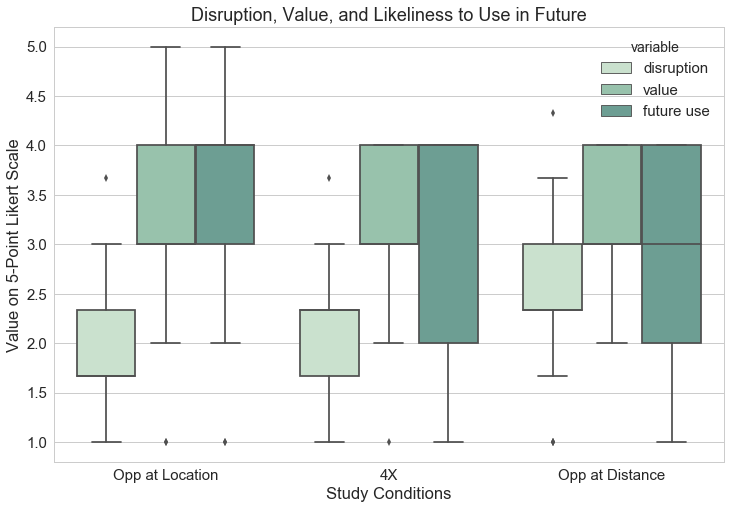

In [816]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=disruption_plot_data,
                 hue_order=['disruption', 'value', 'future use'])
ax.set_title('Disruption, Value, and Likeliness to Use in Future')
ax.set_xlabel('Study Conditions')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [817]:
post_study_opp_loc['overall_disruption'].describe()

count    28.000000
mean      2.095238
std       0.607614
min       1.000000
25%       1.666667
50%       1.666667
75%       2.333333
max       3.666667
Name: overall_disruption, dtype: float64

In [818]:
post_study_4x['overall_disruption'].describe()

count    29.000000
mean      2.080460
std       0.627765
min       1.000000
25%       1.666667
50%       2.333333
75%       2.333333
max       3.666667
Name: overall_disruption, dtype: float64

In [819]:
post_study_opp_dist['overall_disruption'].describe()

count    29.000000
mean      2.540230
std       0.856413
min       1.000000
25%       2.333333
50%       2.333333
75%       3.000000
max       4.333333
Name: overall_disruption, dtype: float64

## Test of Significance on Disruption and Value

In [820]:
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [821]:
# export data for ANOVA in R
anova_data = pd.concat([
    pd.DataFrame({'disruption': post_study_4x['overall_disruption'], 'condition': '4X'}),
    pd.DataFrame({'disruption': post_study_opp_dist['overall_disruption'], 'condition': 'Opportunistic'}),
    pd.DataFrame({'disruption': post_study_opp_loc['overall_disruption'], 'condition': 'Directed'})
])

anova_data.to_csv(path_or_buf='./analysis/anova_data.csv', index=False)

In [822]:
F, p = stats.f_oneway(post_study_4x['overall_disruption'],
                      post_study_opp_dist['overall_disruption'],
                      post_study_opp_loc['overall_disruption'])
d = EffectSize(post_study_4x['overall_disruption'],
               post_study_opp_dist['overall_disruption'],
               post_study_opp_loc['overall_disruption'])

df_btwn, df_within = __degree_of_freedom_(post_study_4x['overall_disruption'],
                                          post_study_opp_dist['overall_disruption'],
                                          post_study_opp_loc['overall_disruption'])

anova_output_string = 'ANOVA on Disruption \nF({}, {}) = {:1.3f}, p = {:1.3f}, Cohen\'s d = {:1.3f}'
print(anova_output_string.format(df_btwn, df_within, F, p, d))

ANOVA on Disruption 
F(2, 83) = 3.935, p = 0.023, Cohen's d = 0.087


In [823]:
F, p = stats.f_oneway(post_study_4x['overall_value'],
                      post_study_opp_dist['overall_value'],
                      post_study_opp_loc['overall_value'])
d = EffectSize(post_study_4x['overall_value'],
               post_study_opp_dist['overall_value'],
               post_study_opp_loc['overall_value'])

print('ANOVA on Value \nF: {:1.3f}, p: {:1.3f}, Cohen\'s d: {:1.3f}'.format(F, p, d))

ANOVA on Value 
F: 0.124, p: 0.884, Cohen's d: 0.003


In [824]:
F, p = stats.f_oneway(post_study_4x['future_use'],
                      post_study_opp_dist['future_use'],
                      post_study_opp_loc['future_use'])
d = EffectSize(post_study_4x['future_use'],
               post_study_opp_dist['future_use'],
               post_study_opp_loc['future_use'])

print('ANOVA on Future Use \nF: {:1.3f}, p: {:1.3f}, Cohen\'s d: {:1.3f}'.format(F, p, d))

ANOVA on Future Use 
F: 1.640, p: 0.200, Cohen's d: 0.038


## Data vs. Pickup Rate vs. Disruption

In [825]:
# task_acceptance_rate_data = pd.DataFrame({
#     'condition': [
#         '4X',
#         'Opp at Distance',
#         'Opp at Location',
#         '4X',
#         'Opp at Distance',
#         'Opp at Distance',
        
#     ],
#     'variable': [
#         'Valid Response Rate \n At Location',
#         'Valid Response Rate \n At Location',
#         'Valid Response Rate \n At Location',
#         'Task Acceptance Rate (with Info) \n 300m Away',
#         'Task Acceptance Rate (with Info) \n 300m Away',
#         'Task Acceptance Rate (without Info) \n 300m Away',
#     ],
#     'value': [
#         float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
#         float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
#         float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
#         float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
#     ]
# })

atdist_taskaccepted = [
    'Yes! This info is useful, I\'m going now.',
    'Sure! I would be happy to go out of my way!'
]

task_acceptance_rate_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Location',
        '4X',
        'Opp at Distance',
    ],
    'variable': [
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Task Acceptance Rate \n 300m Away',
        'Task Acceptance Rate \n 300m Away',
    ],
    'value': [
        float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'].isin(atdist_taskaccepted)]['percentage'].sum())
    ]
})

task_acceptance_rate_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Distance'
    ],
    'variable': [
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (without Info) \n 300m Away',
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
    ]
})

overall_task_acceptance_rate_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance'
    ],
    'variable': [
        'Task Acceptance Rate',
        'Task Acceptance Rate'
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'].isin(atdist_taskaccepted)]['percentage'].sum())
    ]
})

people_notified_atdist_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance'
    ],
    'variable': [
        'Notification Count',
        'Notification Count',
    ],
    'value': [
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Total']['count']),
        float(atdist_opp_dist_all_count_prop_overall[atdist_opp_dist_all_count_prop_overall['emaResponse'] == 'Total']['count'])
    ]
})

disruption_value_data = pd.concat([
    pd.DataFrame({'condition': '4X', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_4x['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_disruption']}),
    pd.DataFrame({'condition': '4X', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_4x['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_value']})
])

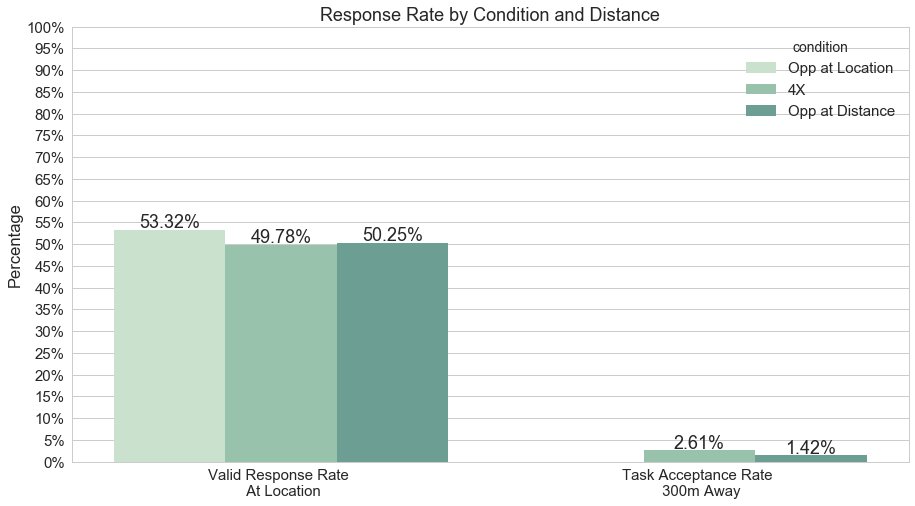

In [826]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Response Rate by Condition and Distance')
ax.set_xlabel('')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_yticklabels(['{}%'.format(x) for x in range(0, 105, 5)])

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 

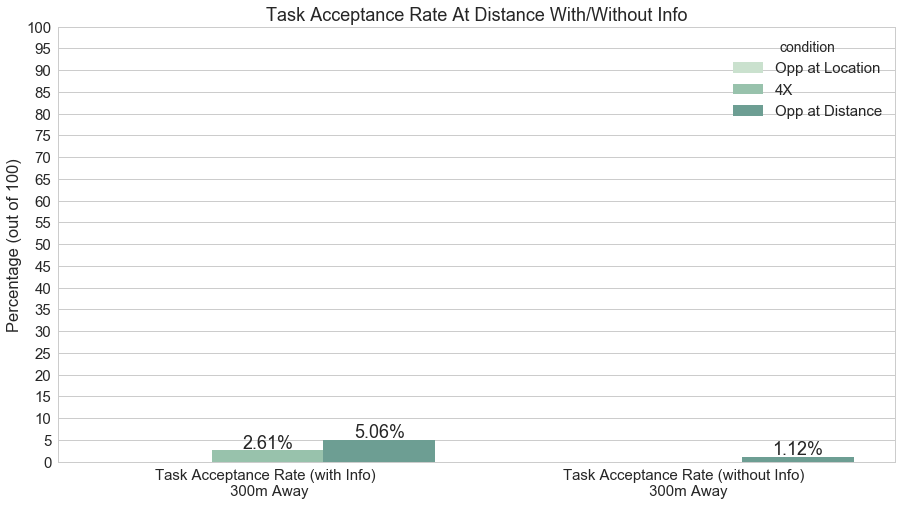

In [827]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_atdist_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Task Acceptance Rate At Distance With/Without Info')
ax.set_xlabel('')
ax.set_ylabel('Percentage (out of 100)')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 

In [828]:
people_notified_atdist_data

,condition,variable,value
0,4X,Notification Count,153.0
1,Opp at Distance,Notification Count,1059.0


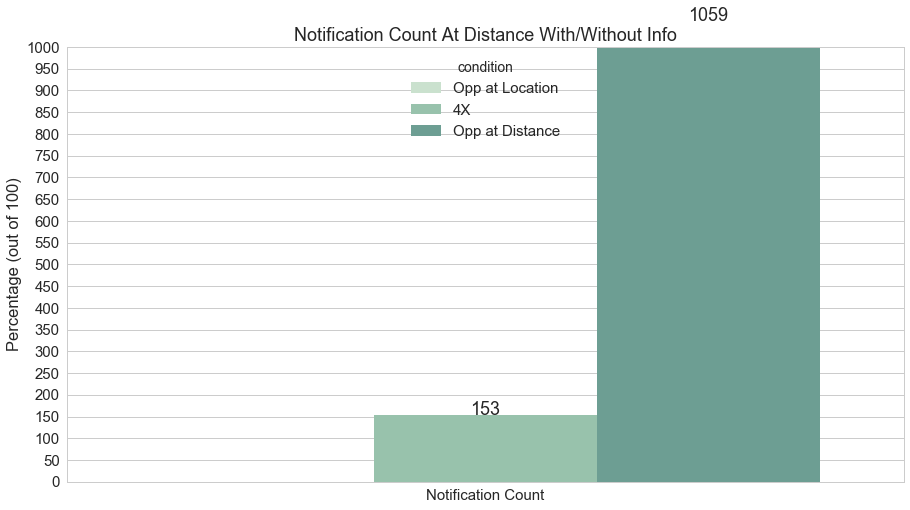

In [829]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='variable', y='value', hue='condition', data=people_notified_atdist_data,
            hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Notification Count At Distance With/Without Info')
ax.set_xlabel('')
ax.set_ylabel('Percentage (out of 100)')
ax.set_ylim(0, 1000)
ax.set_yticks(range(0, 1001, 50))

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.0f}'.format(height), ha="center") 

In [830]:
people_notified_atdist_data

,condition,variable,value
0,4X,Notification Count,153.0
1,Opp at Distance,Notification Count,1059.0


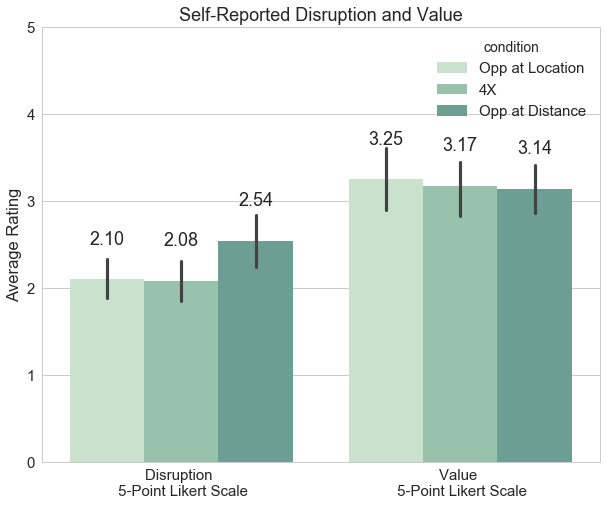

In [831]:
fig = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Self-Reported Disruption and Value')
ax.set_xlabel('')
ax.set_ylabel('Average Rating')
ax.set_ylim(0, 5)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center") 

## Info vs No Info Disruption

In [832]:
info_noinfo_plot_melted_dfs = [
    pd.DataFrame({'condition': 'Opp at Location', 'at location': post_study_opp_loc['explore_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': '4X', 'at location': post_study_4x['explore_disruption'], 'info included': post_study_4x['expand_info_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'at location': post_study_opp_dist['explore_disruption'], 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'info included': post_study_opp_dist['expand_info_disruption']}).melt(id_vars=['condition'])
]
info_disruption_plot_data = pd.concat(info_noinfo_plot_melted_dfs)
info_disruption_plot_data = info_disruption_plot_data[info_disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0,0.5,'Value on 5-Point Likert Scale')

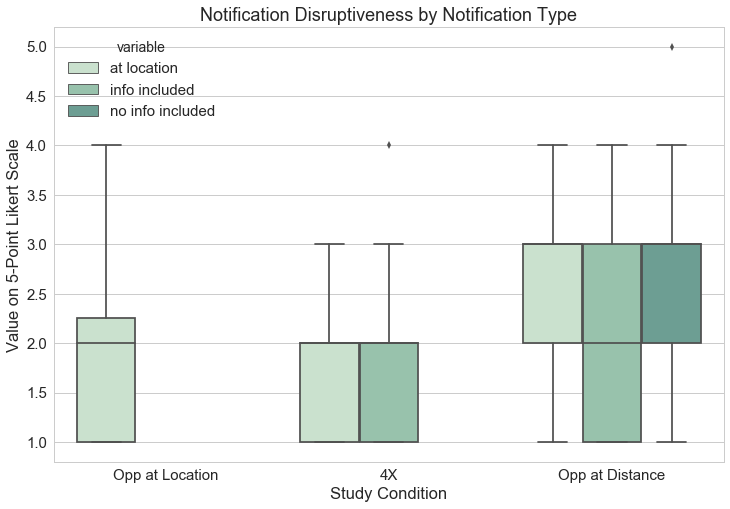

In [833]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_plot_data,
                 hue_order=['at location', 'info included', 'no info included'])
ax.set_title('Notification Disruptiveness by Notification Type')
ax.set_xlabel('Study Condition')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [834]:
info_noinfo_count_plot_melted_dfs = [
    pd.DataFrame({'condition': '4X', 'info included': post_study_4x['expand_info_disruption'], 'info included count': post_study_4x['expand_info_number_notif']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'no info included count': post_study_opp_dist['expand_noinfo_number_notif'],
                  'info included': post_study_opp_dist['expand_info_disruption'], 'info included count': post_study_opp_dist['expand_info_number_notif']}).melt(id_vars=['condition'])
]
info_disruption_count_plot_data = pd.concat(info_noinfo_count_plot_melted_dfs)
info_disruption_count_plot_data = info_disruption_count_plot_data[info_disruption_count_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0.5,1,'Disruptiveness and Desired Count')

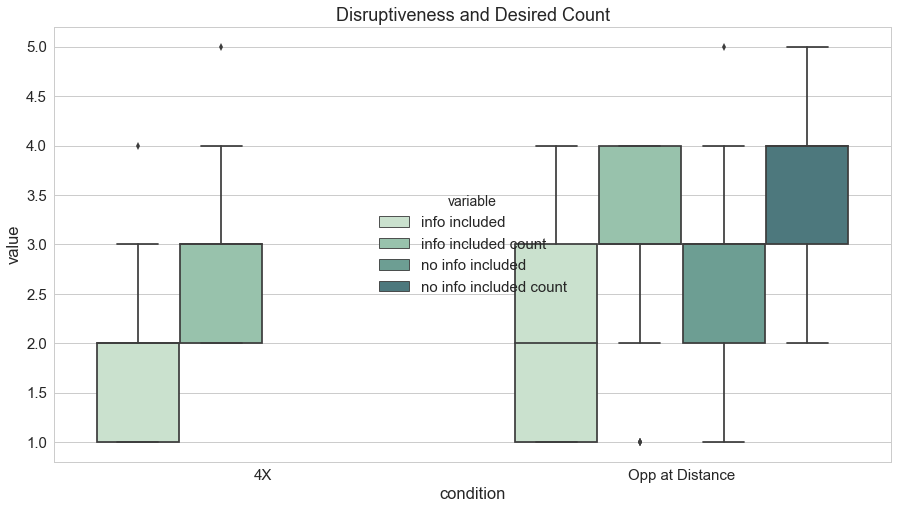

In [835]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_count_plot_data,
                 hue_order=['info included', 'info included count', 'no info included', 'no info included count'])
ax.set_title('Disruptiveness and Desired Count')

## Notification Rates over Time

## Daily

### Opp Distance

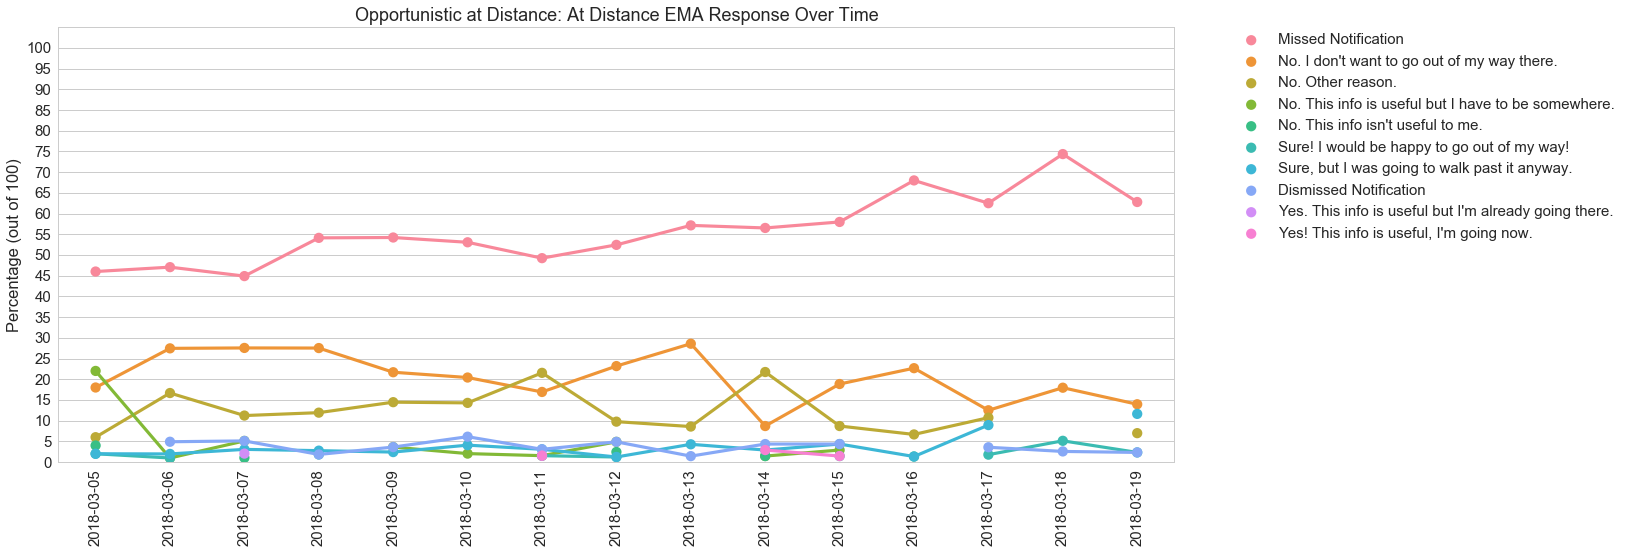

In [836]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_all_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('Opportunistic at Distance: At Distance EMA Response Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

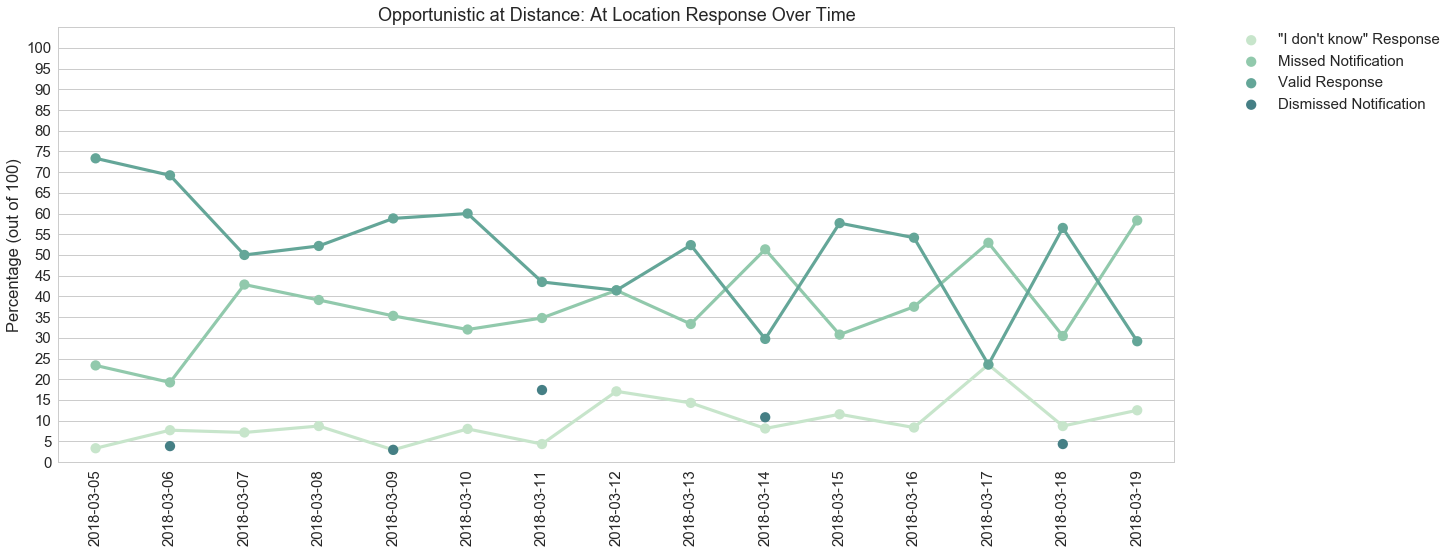

In [837]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_opp_dist_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('Opportunistic at Distance: At Location Response Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### 4X

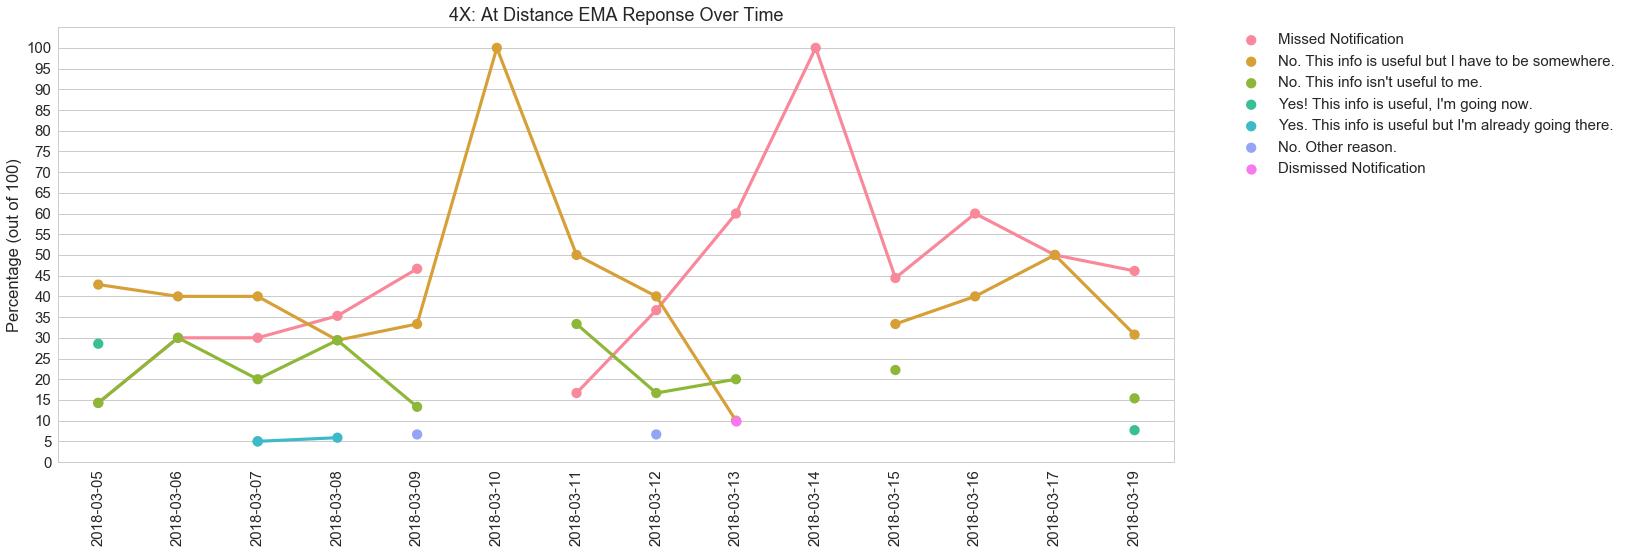

In [838]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_4x_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('4X: At Distance EMA Reponse Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

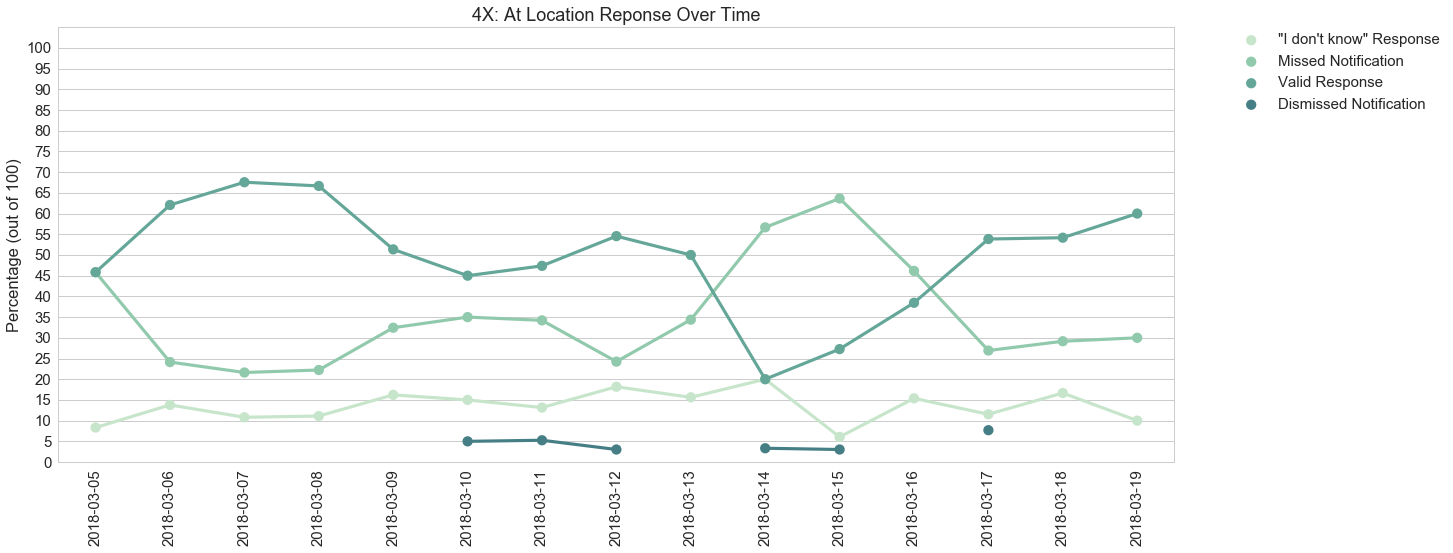

In [839]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_4x_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('4X: At Location Reponse Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Opp Location

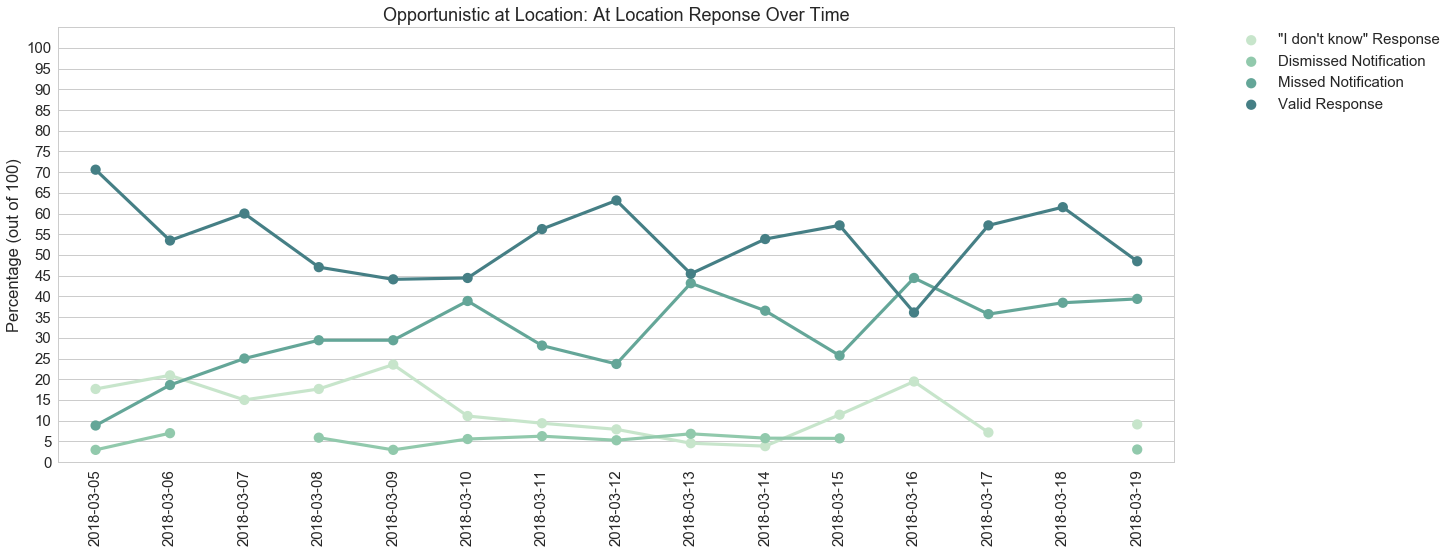

In [840]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_opp_loc_byday_prop)

ax.set_ylabel('Percentage (out of 100)')
ax.set_xlabel('')
ax.set_title('Opportunistic at Location: At Location Reponse Over Time')

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Weekly

### Opp Distance

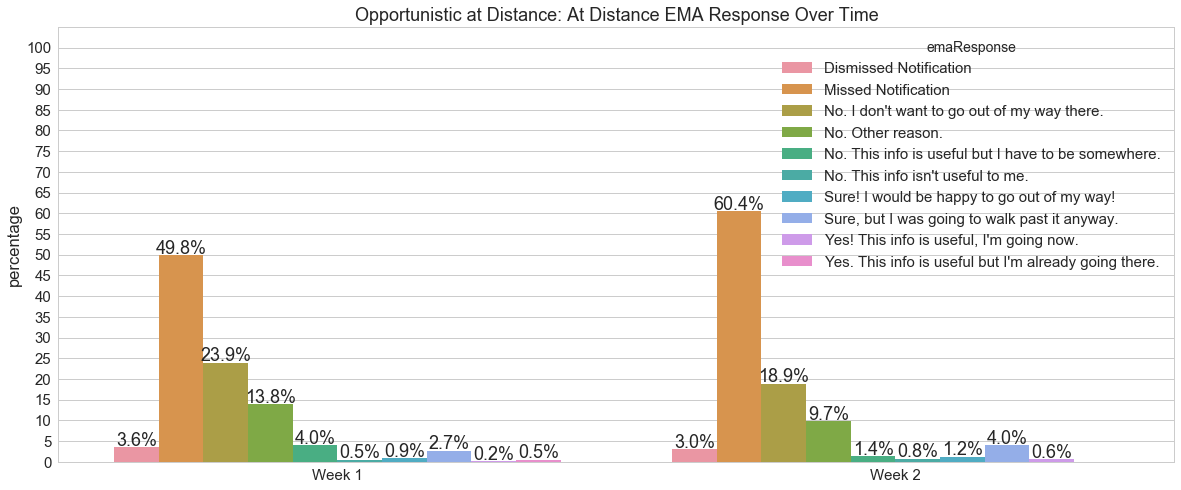

In [841]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_all_byweek_prop)

ax.set_title('Opportunistic at Distance: At Distance EMA Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.1f}%'.format(height), ha="center") 

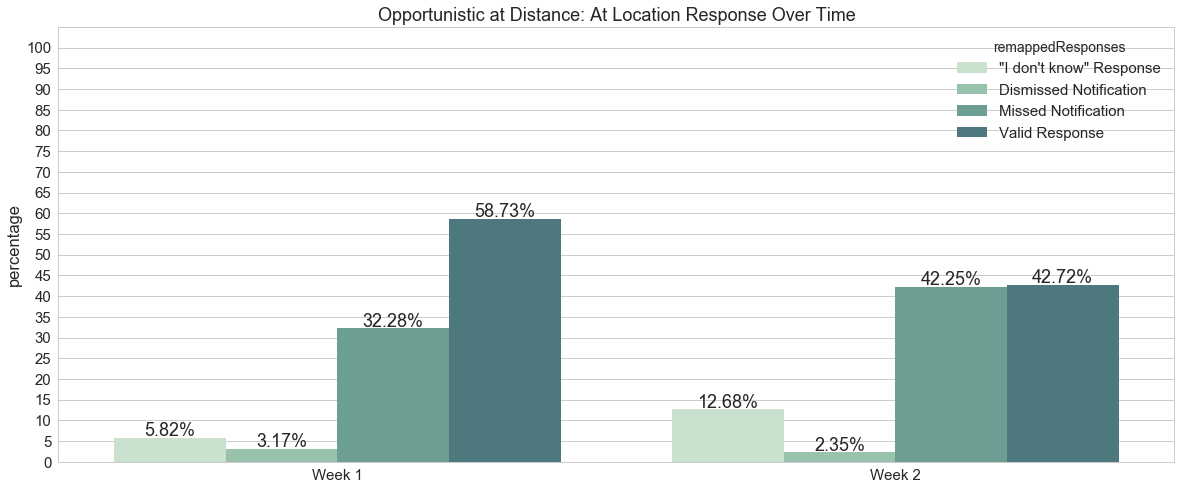

In [842]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_opp_dist_byweek_prop)

ax.set_title('Opportunistic at Distance: At Location Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

### 4X

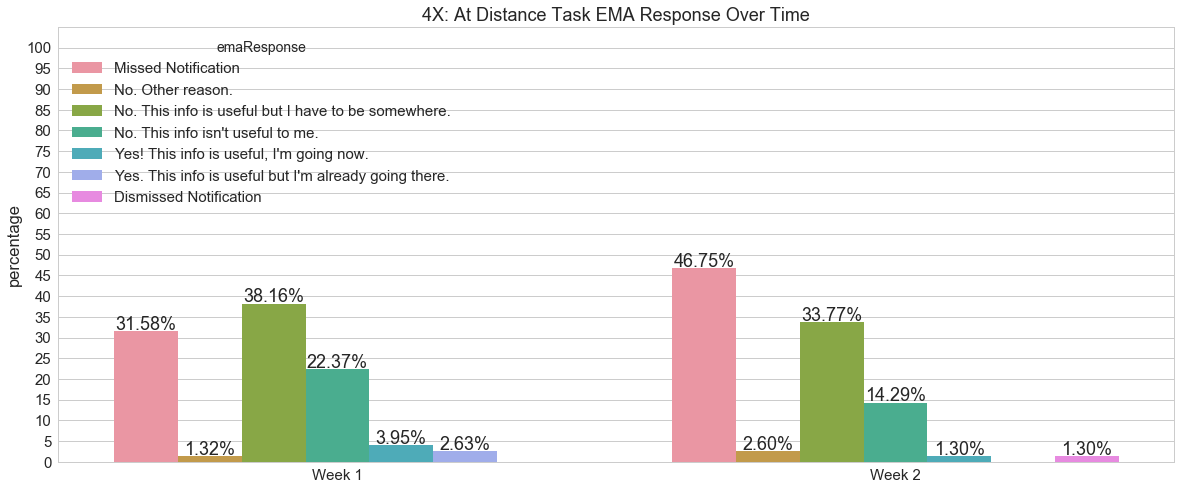

In [843]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_4x_byweek_prop)
ax.set_title('4X: At Distance Task EMA Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

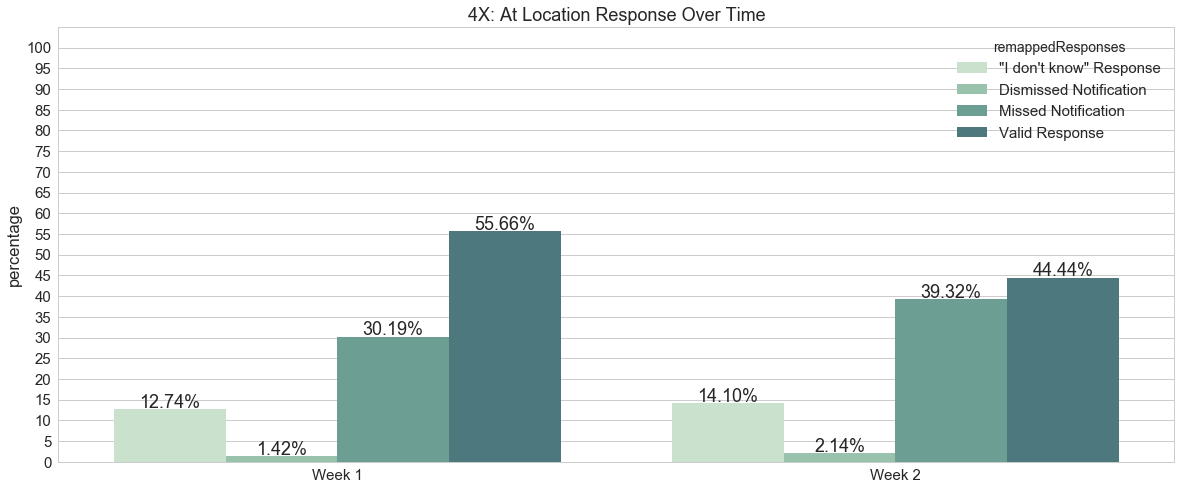

In [844]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_4x_byweek_prop)
ax.set_title('4X: At Location Response Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

### Opp Location

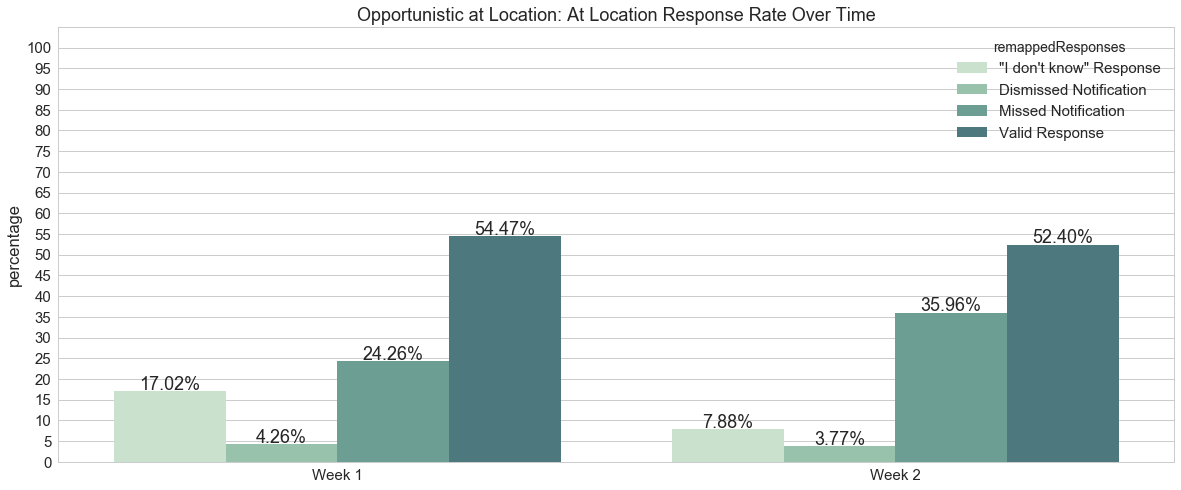

In [845]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_opp_loc_byweek_prop)
ax.set_title('Opportunistic at Location: At Location Response Rate Over Time')
ax.set_xlabel('')
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))

loc, labels = plt.xticks()
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}%'.format(height), ha="center") 

## Scaffolding by Condition and Location

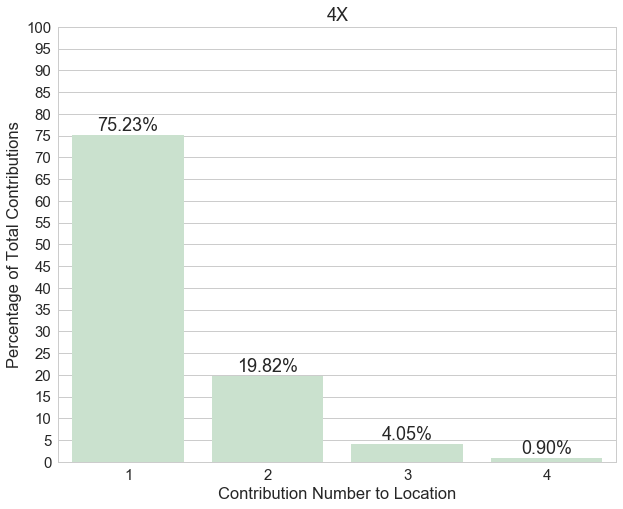

In [846]:
# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

atloc_4x_contrib_hist = atloc_4x[atloc_4x['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_4x_contrib_hist = atloc_4x_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_4x_contrib_hist['total_count'] = atloc_4x_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_4x_contrib_hist['proportion'] = 100 * atloc_4x_contrib_hist['total_count'] / sum(atloc_4x_contrib_hist['total_count'])

ax = sns.barplot(data=atloc_4x_contrib_hist,
                 x='count', y='proportion', color=sns.color_palette()[0])
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('4X')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 

In [847]:
atloc_4x_contrib_hist

,count,instances,total_count,proportion
0,1,123,167,75.225225
1,2,35,44,19.819820
2,3,7,9,4.054054
3,4,2,2,0.900901


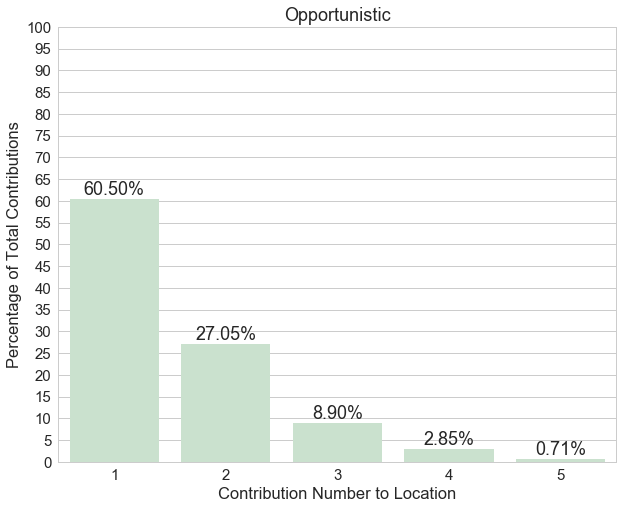

In [848]:
# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

atloc_opp_loc_contrib_hist = atloc_opp_loc[atloc_opp_loc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_loc_contrib_hist = atloc_opp_loc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_loc_contrib_hist['total_count'] = atloc_opp_loc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_loc_contrib_hist['proportion'] = 100 * atloc_opp_loc_contrib_hist['total_count'] / sum(atloc_opp_loc_contrib_hist['total_count'])

ax = sns.barplot(data=atloc_opp_loc_contrib_hist,
                 x='count', y='proportion', color=sns.color_palette()[0])
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('Opportunistic')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 

In [849]:
atloc_opp_loc_contrib_hist

,count,instances,total_count,proportion
0,1,94,170,60.498221
1,2,51,76,27.046263
2,3,17,25,8.896797
3,4,6,8,2.846975
4,5,2,2,0.711744


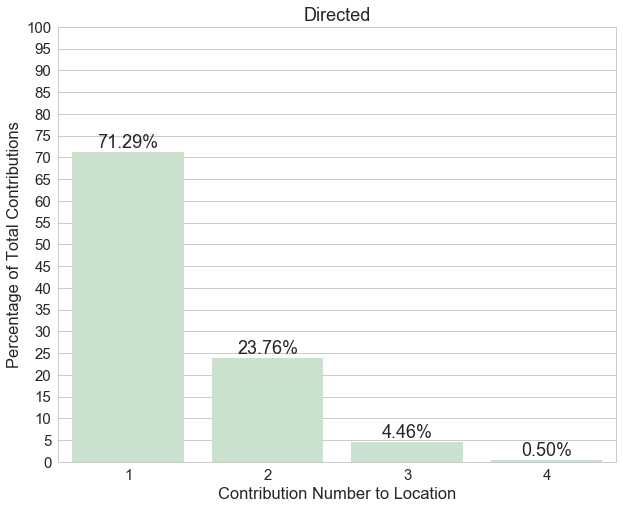

In [850]:
# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

atloc_opp_dist_contrib_hist = atloc_opp_dist[atloc_opp_dist['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_dist_contrib_hist = atloc_opp_dist_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_dist_contrib_hist['total_count'] = atloc_opp_dist_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_dist_contrib_hist['proportion'] = 100 * atloc_opp_dist_contrib_hist['total_count'] / sum(atloc_opp_dist_contrib_hist['total_count'])

ax = sns.barplot(data=atloc_opp_dist_contrib_hist,
                 x='count', y='proportion', color=sns.color_palette()[0])
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('Directed')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 

In [851]:
atloc_opp_dist_contrib_hist

,count,instances,total_count,proportion
0,1,96,144,71.287129
1,2,39,48,23.762376
2,3,8,9,4.455446
3,4,1,1,0.495050


## For You Views

In [852]:
foryou_4x_byweek_count

,week,logString,count,condition
0,Week 1,User has viewed For You view on iOS.,119,4X
1,Week 2,User has viewed For You view on iOS.,84,4X


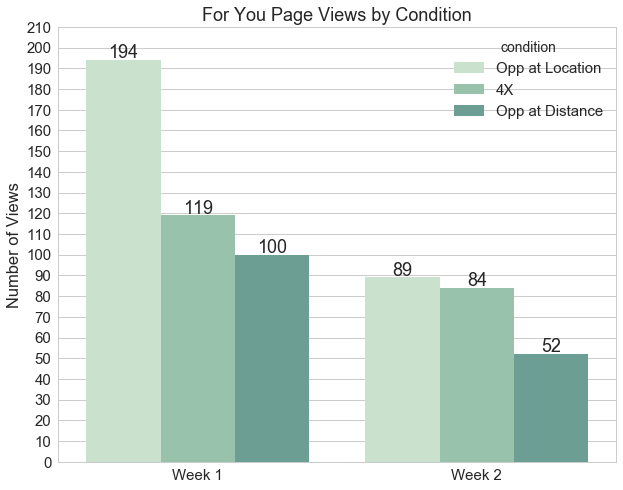

In [853]:
foryou_data = pd.concat([
    foryou_4x_byweek_count,
    foryou_opp_loc_byweek_count,
    foryou_opp_dist_byweek_count
])

# histogram of locations by number of contributions
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.barplot(data=foryou_data, x='week', y='count', hue='condition',
                hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set(xlabel='', ylabel='Number of Views')
ax.set_ylim(0, 210)
ax.set_yticks(range(0, 211, 10))
ax.set_title('For You Page Views by Condition')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.0f}'.format(height), ha="center") 

# Paper Plots
This code is used to generate the final plots that will be used in the paper

## Response Rate and Disruption
Left: Response rate At Location and Task Acceptance Rate 300m from location. For 4X, 300m notifications were only sent when preferential data was available, while for Opp at Distance notifications were always sent.  We see that the task acceptance rate is lower for Opp at Distance compared to 4X, with all three conditions having roughly the same At Location response rate.

Right: Self-reported disruption and value of LES. Opp at Distance has significantly higher disruption than either Opp at Location or 4X (F: 3.935, p: 0.023, Cohen's d: 0.087). From the self-reported value, each system is shown to be approximately equally valuable. However, further analysis of the qualitative data indicates that Opp at Location users did not feel they gained much value from the application and wished that it notified them when information was available, similar to 4X.

In [854]:
# remap variable names
graph_replacement_dict = {
    'condition': {
        'Opp at Distance': 'Directed',
        'Opp at Location': 'Opportunistic'
    }
}
task_acceptance_rate_data.replace(graph_replacement_dict, inplace=True)
disruption_value_data.replace(graph_replacement_dict, inplace=True)

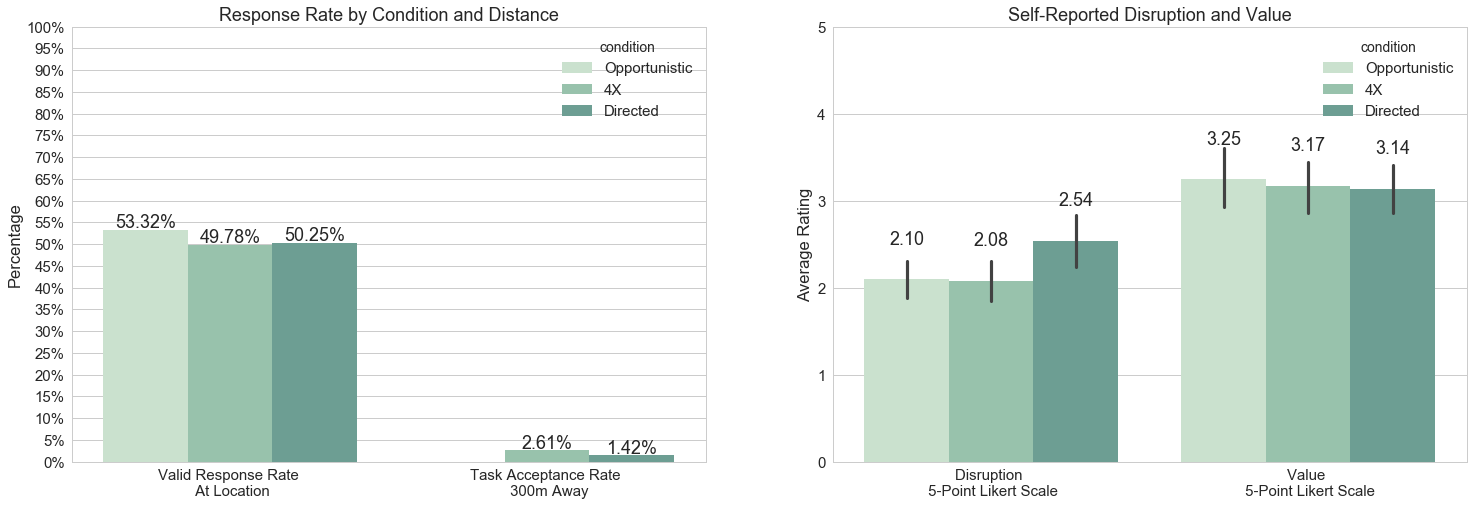

In [855]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(25, 8))

# create acceptance rate plot
sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax1)
ax1.set_title('Response Rate by Condition and Distance')
ax1.set_xlabel('')
ax1.set_ylabel('Percentage')
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 5))
ax1.set_yticklabels(['{}%'.format(x) for x in range(0, 105, 5)])

for p in ax1.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax1.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax1.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 
        
# create disruption plot
sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax2)
ax2.set_title('Self-Reported Disruption and Value')
ax2.set_xlabel('')
ax2.set_ylabel('Average Rating')
ax2.set_ylim(0, 5)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center") 
    
# export plot
output_fig = ax2.get_figure()
output_fig.savefig('./graphs/acceptance-disruption.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

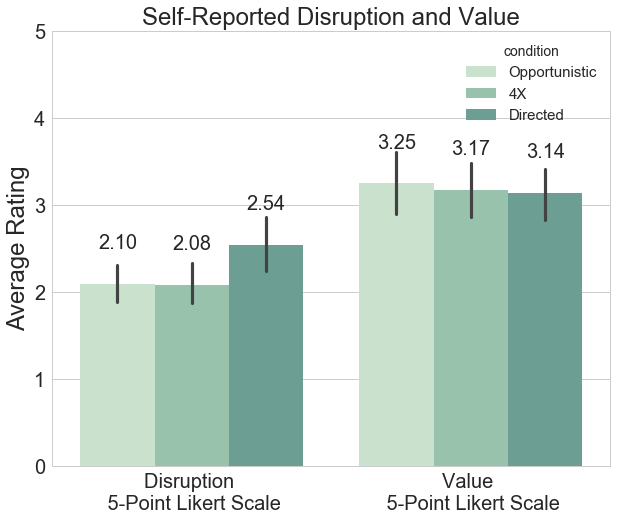

In [856]:
fig, ax = plt.subplots(figsize=(10, 8))

# create disruption plot
sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
            hue_order=['Opportunistic', '4X', 'Directed'], ax=ax)
ax.set_title('Self-Reported Disruption and Value', fontsize=24)
ax.set_xlabel('', fontsize=24)
ax.set_ylabel('Average Rating', fontsize=24)
ax.set_ylim(0, 5)
ax.tick_params(labelsize=20)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center", fontsize=20) 
    
# export plot
output_fig = ax.get_figure()
output_fig.savefig('./graphs/disruption.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

## Data Scaffolding

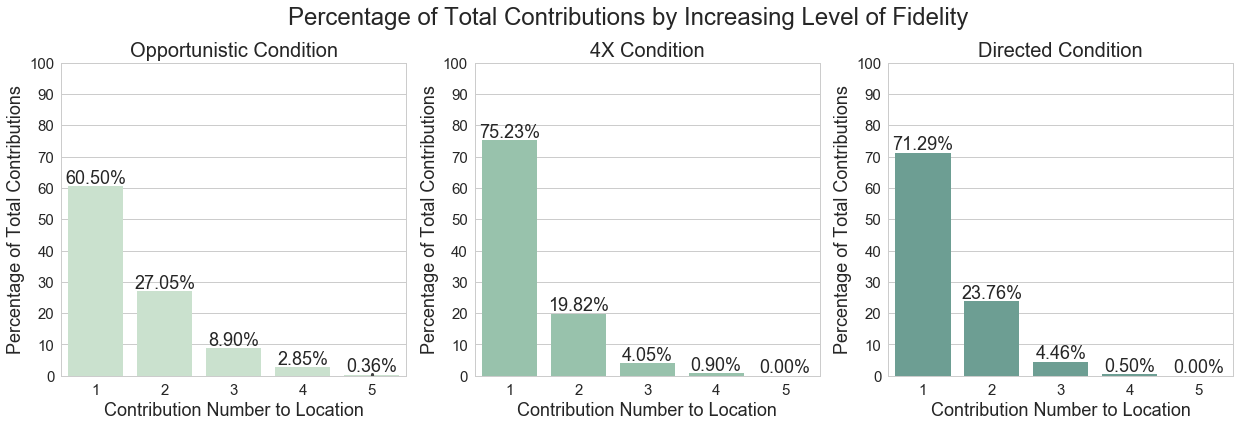

In [857]:
# histogram of locations by number of contributions
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(21, 6))
plt.subplots_adjust(top=0.85)
        
# opportunistic
atloc_opp_loc_contrib_hist = atloc_opp_loc[atloc_opp_loc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_loc_contrib_hist = atloc_opp_loc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_loc_contrib_hist['total_count'] = atloc_opp_loc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_loc_contrib_hist['proportion'] = 100 * atloc_opp_loc_contrib_hist['total_count'] / sum(atloc_opp_loc_contrib_hist['total_count'])
atloc_opp_loc_contrib_hist = pd.concat([atloc_opp_loc_contrib_hist, 
                                        pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_opp_loc_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[0], ax=ax1)
ax1.set_xlabel('Contribution Number to Location', fontsize=18)
ax1.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 10))
ax1.set_title('Opportunistic Condition', fontsize=20)

# Get current axis on current figure
for p in ax1.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax1.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center")
        
# 4X
atloc_4x_contrib_hist = atloc_4x[atloc_4x['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_4x_contrib_hist = atloc_4x_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_4x_contrib_hist['total_count'] = atloc_4x_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_4x_contrib_hist['proportion'] = 100 * atloc_4x_contrib_hist['total_count'] / sum(atloc_4x_contrib_hist['total_count'])
atloc_4x_contrib_hist = pd.concat([atloc_4x_contrib_hist, 
                                   pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_4x_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[1], ax=ax2)
ax2.set_xlabel('Contribution Number to Location', fontsize=18)
ax2.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax2.set_ylim(0, 100)
ax2.set_yticks(range(0, 101, 10))
ax2.set_title('4X Condition', fontsize=20)

# Get current axis on current figure
for p in ax2.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax2.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 
        
# directed
atloc_opp_dist_contrib_hist = atloc_opp_dist[atloc_opp_dist['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_dist_contrib_hist = atloc_opp_dist_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_dist_contrib_hist['total_count'] = atloc_opp_dist_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_dist_contrib_hist['proportion'] = 100 * atloc_opp_dist_contrib_hist['total_count'] / sum(atloc_opp_dist_contrib_hist['total_count'])
atloc_opp_dist_contrib_hist = pd.concat([atloc_opp_dist_contrib_hist, 
                                         pd.DataFrame({'count': [5], 'instances': [0], 'total_count': [0], 'proportion': [0.0]})])

sns.barplot(data=atloc_opp_dist_contrib_hist,
            x='count', y='proportion', color=sns.color_palette()[2], ax=ax3)
ax3.set_xlabel('Contribution Number to Location', fontsize=18)
ax3.set_ylabel('Percentage of Total Contributions', fontsize=18)
ax3.set_ylim(0, 100)
ax3.set_yticks(range(0, 101, 10))
ax3.set_title('Directed Condition', fontsize=20)

# Get current axis on current figure
for p in ax3.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax3.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 
        
# export plot
fig.suptitle('Percentage of Total Contributions by Increasing Level of Fidelity', fontsize=24)
output_fig = ax3.get_figure()
output_fig.savefig('./graphs/data-scaffolding.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

In [858]:
# combined scaffolding data
combined_scaffolding_graph = pd.concat([atloc_opp_loc_contrib_hist, atloc_4x_contrib_hist, atloc_opp_dist_contrib_hist])[['count', 'total_count']]
combined_scaffolding_graph = combined_scaffolding_graph.groupby('count')['total_count'].sum().reset_index()
combined_scaffolding_graph['proportion'] = 100 * combined_scaffolding_graph['total_count'] / sum(combined_scaffolding_graph['total_count'])
combined_scaffolding_graph

,count,total_count,proportion
0,1,481,68.226950
1,2,168,23.829787
2,3,43,6.099291
3,4,11,1.560284
4,5,2,0.283688


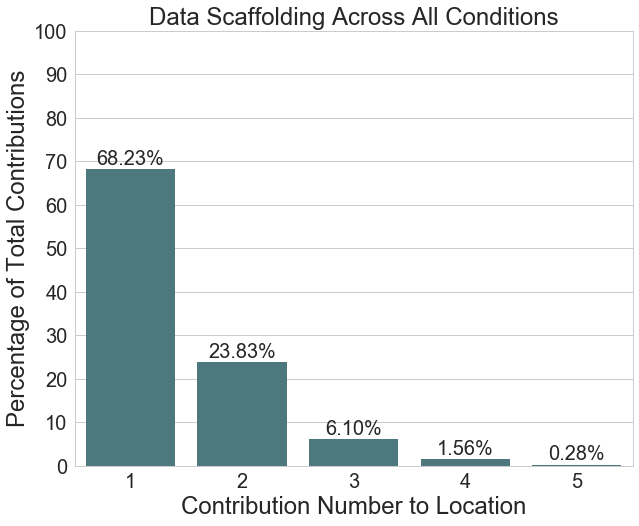

In [859]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=combined_scaffolding_graph, color=sns.color_palette()[3],
            x='count', y='proportion', ax=ax)
ax.set_xlabel('Contribution Number to Location', fontsize=24)
ax.set_ylabel('Percentage of Total Contributions', fontsize=24)

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.set_title('Data Scaffolding Across All Conditions', fontsize=24)
ax.tick_params(labelsize=20)

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center", fontsize=20) 
        
output_fig = ax.get_figure()
output_fig.savefig('./graphs/data-scaffolding-all.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0) 

In [860]:
# opportunistic
atloc_opp_loc_contrib_hist = atloc_opp_loc[atloc_opp_loc['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_loc_contrib_hist = atloc_opp_loc_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_loc_contrib_hist['total_count'] = atloc_opp_loc_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_loc_contrib_hist['proportion'] = 100 * atloc_opp_loc_contrib_hist['total_count'] / sum(atloc_opp_loc_contrib_hist['total_count'])
atloc_opp_loc_contrib_hist['condition'] = 'Opportunistic'

# 4X
atloc_4x_contrib_hist = atloc_4x[atloc_4x['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_4x_contrib_hist = atloc_4x_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_4x_contrib_hist['total_count'] = atloc_4x_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_4x_contrib_hist['proportion'] = 100 * atloc_4x_contrib_hist['total_count'] / sum(atloc_4x_contrib_hist['total_count'])
atloc_4x_contrib_hist['condition'] = '4X'

# directed
atloc_opp_dist_contrib_hist = atloc_opp_dist[atloc_opp_dist['remappedResponses'] == 'Valid Response'].groupby(['taskLocationId', 'locationName', 'locationType'])['taskLocationId'].count().reset_index(name='count')
atloc_opp_dist_contrib_hist = atloc_opp_dist_contrib_hist.groupby('count')['taskLocationId'].count().reset_index(name='instances')
atloc_opp_dist_contrib_hist['total_count'] = atloc_opp_dist_contrib_hist['instances'][::-1].cumsum()[::-1]
atloc_opp_dist_contrib_hist['proportion'] = 100 * atloc_opp_dist_contrib_hist['total_count'] / sum(atloc_opp_dist_contrib_hist['total_count'])
atloc_opp_dist_contrib_hist['condition'] = 'Directed'

# combined plot data 
contribution_hist_data = pd.concat([atloc_opp_loc_contrib_hist, atloc_4x_contrib_hist, atloc_opp_dist_contrib_hist])

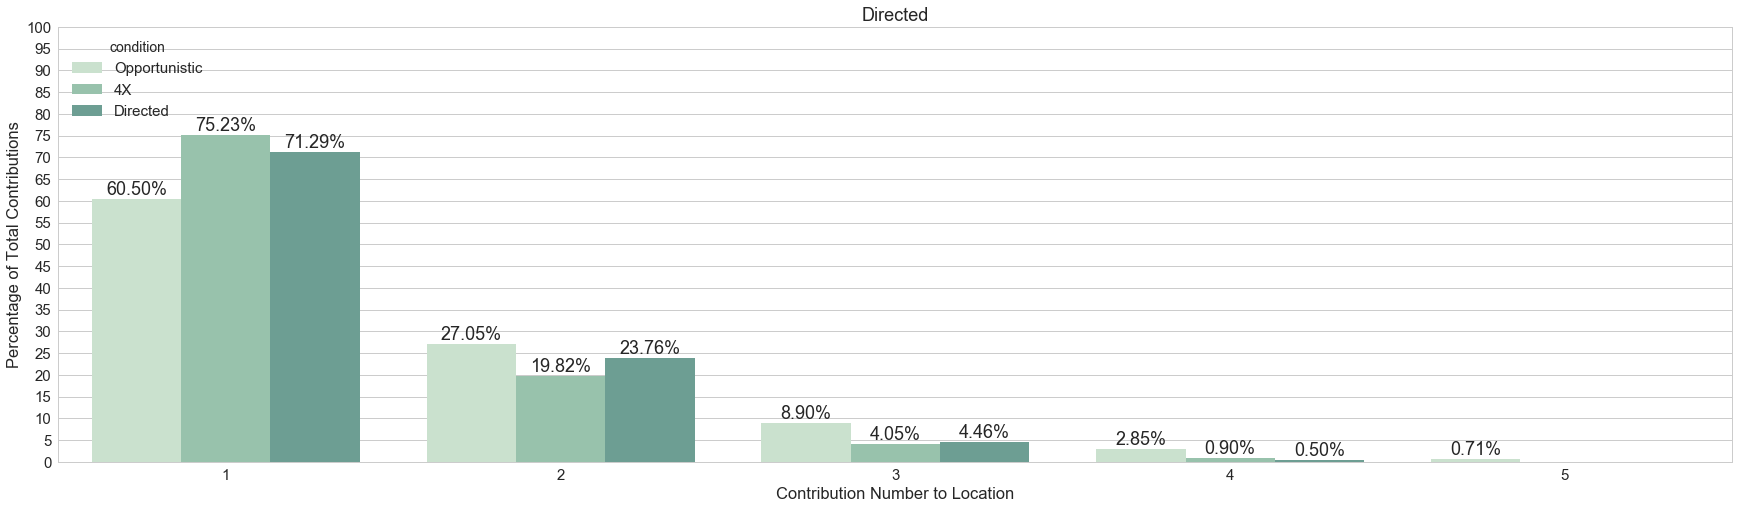

In [861]:
fig, ax = plt.subplots(figsize=(30, 8))

sns.barplot(data=contribution_hist_data,
            x='count', y='proportion', hue='condition', ax=ax)
ax.set(xlabel='Contribution Number to Location',
       ylabel='Percentage of Total Contributions')
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 5))
ax.set_title('Directed')

# Get current axis on current figure
for p in ax.patches:
    height = p.get_height()
    if not math.isnan(height):
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}%'.format(height), ha="center") 